# * TVS Performance *

## Note :

#### Responsible :
- K.Ongard Prapakamol (K.?)
- True Visions (TVS) and Media
- ongard_pra@truecorp.co.th

#### Issue :
- ตัวเลขที่ BU รายงานไม่ตรงกับ VINSIGHT
- BU น่าจะใช้ข้อมูล P'Song
- ประเด็นคือมี 2 source(ข้อมูล DWH, ข้อมูล P'Song)
- Revenue(ตัวเลข Corp Plan): ยอดหาย เพราะรอบบิลสุดท้ายไม่เข้า และเรื่อง sharing
- Active Subs: ยอด over เพราะ Corp Plan รวม data บางกลุ่มมาด้วย เช่น TrueID TV

#### Solving :
- Revenue: พี่โบว์จะไป check และ update เรื่องรอบบิลสุดท้ายให้
- Active Subs: ต้อง filter บางตัวออก เพื่อให้ align กับ target
- พี่อ้อยจะส่งตัวเลขเดือน June มาให้ฝั่ง VINSIGHT เพื่อ verify
- VINSIGHT อาจจะปรับให้กับ BU ได้(หากไม่มีตัวเลข adjustment)

#### Other :
- Actual Source: มากจาก DWH หรือ P'Song ???
- Target เป็นตัวเลข Finance(รวมถึงตัวเลขที่มีการ adjustment)
- BU: confirm ว่าเค้าไม่มีการ adjustment

## Import Data Source

In [57]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [58]:
''' Config '''

config = configparser.ConfigParser()
config.read('../../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']
v_product = 'TVS'

In [59]:
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 
        'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
tvs_rev_cd_list = ['TB4R000100CORP', 'TB4R000101CORP', 'TB4R000102CORP'] # 'TVS Revenue', 'TVS New Revenue', 'TVS Existing Revenue'
tvs_sale_sub_cd_list = ['TB4S000100', 'TB4S000101', 'TB4S000102', 'TB4S000103', 'TB4S000104'] # 'TVS Gross Add', 'TVS New Subs : Premium', 'TVS New Subs : Mid', 'TVS New Subs Mass', 'TVS New Subs TVS Now'
# tvs_sale_rev_cd_list = ['TB4R001000'] # 'TVS Inflow M1'
tvs_sub_cd_list = ['TB4S000400', 'TB4S000500'] # 'TVS Net Add', 'TVS Active Subs'
tvs_churn_cd_list = ['TSER14100'] # 'TVS Churn Subs'
tvs_all_cd_list = tvs_rev_cd_list + tvs_sale_sub_cd_list + tvs_sub_cd_list + tvs_churn_cd_list

In [60]:
df.shape

(169496, 24)

In [61]:
''' Find Metric '''

df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND'])\
    .agg({'ACTUAL_SNAP': 'sum', 'ACTUAL_AGG': 'sum', 'TARGET_SNAP': 'sum', 'TARGET_AGG': 'sum', 'BASELINE_SNAP':'sum', 'BASELINE_AGG':'sum', 'TM_KEY_DAY':'max'}).reset_index()
# df_agg_n = df.loc[df[(df['AGG_TYPE']=='N') & (df['ACTUAL_SNAP']>0)].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND', 
                     'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'TM_KEY_DAY']]
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric = df_metric.rename(columns={'TM_KEY_DAY':'MAX_DAY'})
df_metric['ACTUAL_SNAP'] = df_metric['ACTUAL_SNAP'] / 1000000
df_metric['ACTUAL_AGG'] = df_metric['ACTUAL_AGG'] / 1000000
df_metric['TARGET_SNAP'] = df_metric['TARGET_SNAP'] / 1000000
df_metric['TARGET_AGG'] = df_metric['TARGET_AGG'] / 1000000
df_metric['BASELINE_SNAP'] = df_metric['BASELINE_SNAP'] / 1000000
df_metric['BASELINE_AGG'] = df_metric['BASELINE_AGG'] / 1000000
# df_metric

''' Filters '''
# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TVS"]
# df_tmp = df_tmp[df_tmp['CENTER']=="Sales & Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Subs"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]
df_tmp = df_metric[df_metric['METRIC_CD'].isin(tvs_all_cd_list)]
df_tmp = df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD']).reset_index()

# df_tmp.to_excel('TVS_Metric.xlsx', index=False)
df_tmp

,index,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,GRY_IND,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,BASELINE_SNAP,BASELINE_AGG,MAX_DAY
0,41,Revenue,Retention & Churn,TRUE,TVS,TSER14100,TVS Churn Subs,S,RYG,0.155055,2.352725,0.140314,2.175821,0.147627,2.288858,20231112
1,97,Revenue,Revenue,TRUE,TVS,TB4R000100CORP,TVS Revenue,S,GYR,3180.721352,34441.037148,3417.588531,39650.661680,0.000000,0.000000,20231112
2,99,Revenue,Revenue,TRUE,TVS,TB4R000101CORP,TVS New Revenue,S,GYR,195.276110,2883.018557,463.623242,6503.508112,0.000000,0.000000,20231112
3,101,Revenue,Revenue,TRUE,TVS,TB4R000102CORP,TVS Existing Revenue,S,GYR,2984.948157,31583.815210,2953.965290,33147.153568,0.000000,0.000000,20231112
4,378,Revenue,Sales,TRUE,TVS,TB4S000100,TVS Gross Add,S,GYR,0.061253,0.978535,0.087234,1.344678,0.000000,0.000000,20231112
5,388,Revenue,Sales,TRUE,TVS,TB4S000101,TVS Gross Add : Premium,S,GYR,0.009132,0.141313,0.000000,0.000000,0.000000,0.000000,20231112
6,389,Revenue,Sales,TRUE,TVS,TB4S000102,TVS Gross Add : Mid,S,GYR,0.007203,0.122290,0.000000,0.000000,0.000000,0.000000,20231112
7,390,Revenue,Sales,TRUE,TVS,TB4S000103,TVS Gross Add : Mass,S,GYR,0.044918,0.714932,0.000000,0.000000,0.000000,0.000000,20231112
8,391,Revenue,Sales,TRUE,TVS,TB4S000104,TVS Gross Add : TVS Now,S,GYR,0.019016,0.304098,0.000000,0.000000,0.000000,0.000000,20231112
9,405,Revenue,Subs,TRUE,TVS,TB4S000400,TVS Net Add,S,GYR,-0.093802,-1.374190,-0.053080,-0.831143,-0.147627,-2.288858,20231112


## Data Preporation

In [62]:
''' Functions '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

def unit_k(baht):
    n = baht
    unit_k = n / 1000
    return unit_k

In [63]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202310] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023029] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(tvs_all_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG', 'BASELINE_SNAP':'BL_SNAP', 'BASELINE_AGG':'BL_AGG'})

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,BL_SNAP,BL_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
158956,20231110,2023045,202311,20234,2023,Revenue,Revenue,TRUE,TVS,TB4R000100CORP,...,3.420024e+07,8.698002e+07,4.452083e+07,1.086578e+08,0.0,0.0,2023-11-13 07:09:26,November,45,10
158957,20231111,2023045,202311,20234,2023,Revenue,Revenue,TRUE,TVS,TB4R000100CORP,...,NaN,8.698002e+07,NaN,1.086578e+08,NaN,0.0,2023-11-13 07:09:26,November,45,11
158958,20231112,2023045,202311,20234,2023,Revenue,Revenue,TRUE,TVS,TB4R000100CORP,...,NaN,8.698002e+07,NaN,1.086578e+08,NaN,0.0,2023-11-13 07:09:26,November,45,12


In [64]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

In [65]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [66]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 
            'AGG_TYPE', 'GRY_IND', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG', 'BL_SNAP', 'BL_AGG']
df_day = df[cols_agg].reset_index()

''' Aggregation '''
df_day['ACT'] = np.where(df_day['AGG_TYPE']=='N', df_day['ACT_AGG'], df_day['ACT_SNAP'])
df_day['TGT'] = np.where(df_day['AGG_TYPE']=='N', df_day['TGT_AGG'], df_day['TGT_SNAP'])
# df_day['%ACHV'] = df_day['ACT'] / df_day['TGT']
df_day['%ACHV'] = np.where(df_day['METRIC_NAME'].str.contains("Churn"), -((df_day['ACT']/df_day['TGT'])-1), df_day['ACT']/df_day['TGT']) 
df_day['GAP'] = df_day['ACT'] - df_day['TGT']
df_day['LAST_ACT'] = df_day.groupby('METRIC_CD')['ACT'].shift()
df_day['DIFF'] = df_day['ACT'] - df_day['LAST_ACT']
df_day['%DOD'] = (df_day['ACT'] / df_day['LAST_ACT']) - 1

# df_day.to_excel('df_day.xlsx', index=False)
df_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,TGT_AGG,BL_SNAP,BL_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
2824,158956,TB4R000100CORP,TVS Revenue,20231110,2023045,202311,20234,2023,November,10,...,1.086578e+08,0.0,0.0,3.420024e+07,4.452083e+07,0.768185,-1.032059e+07,NaN,NaN,NaN
2825,158957,TB4R000100CORP,TVS Revenue,20231111,2023045,202311,20234,2023,November,11,...,1.086578e+08,NaN,0.0,NaN,NaN,NaN,NaN,3.420024e+07,NaN,NaN
2826,158958,TB4R000100CORP,TVS Revenue,20231112,2023045,202311,20234,2023,November,12,...,1.086578e+08,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
''' Fix Columns Dict '''

cols_dict = {'TVS Revenue':'TOTAL', 'TVS New Revenue':'NEW', 'TVS Existing Revenue':'EXIST', 
             'TVS Net Add':'NET_ADD', 'TVS Active Subs':'ACTV_SUB', 'TVS Churn Subs':'CHRN_SUB', 
             'TVS Gross Add':'NEW_SUB', 'TVS Gross Add : Premium':'NEW_SUB_PREM', 'TVS Gross Add : Mid':'NEW_SUB_MID', 'TVS Gross Add : Mass':'NEW_SUB_MASS', 'TVS Gross Add : TVS Now':'NEW_SUB_NOW'}


In [68]:
''' Pivot by KPIS '''

df_day_agg = df_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR  MTH_DESC  \
METRIC_NAME                                                                  
254           20231110   2023045     202311      20234      2023  November   
255           20231111   2023045     202311      20234      2023  November   
256           20231112   2023045     202311      20234      2023  November   

            DAY_LABEL        ACT                         ...      %DOD        \
METRIC_NAME             ACTV_SUB CHRN_SUB         EXIST  ...  CHRN_SUB EXIST   
254                10  1337222.0    293.0  2.958311e+07  ... -0.244845   NaN   
255                11  1337438.0   1733.0           NaN  ...  4.914676   NaN   
256                12  1337542.0      NaN           NaN  ...       NaN   NaN   

                                                                         \
METRIC_NAME   NEW_SUB NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM NEW_SUB_NOW   
254         -0.112903    -0.155440   -0.035714     0.111111   -0.138211   
255          0.204545     0.361963   -0.259259    -0.233333         NaN   
256               NaN          NaN         NaN          NaN         NaN   

                                  
METRIC_NAME    NET_ADD NEW TOTAL  
254          -0.478571 NaN   NaN  
255          19.109589 NaN   NaN  
256                NaN NaN   NaN  

[3 rows x 84 columns]

## ** Yearly **

### YR : Aggregation

In [69]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_yr['%ACHV'] = np.where(df_yr['METRIC_NAME'].str.contains("Churn"), -((df_yr['ACT']/df_yr['TGT'])-1), df_yr['ACT']/df_yr['TGT']) 
df_yr['GAP'] = df_yr['ACT'] - df_yr['TGT']
df_yr['LAST_ACT'] = df_yr.groupby('METRIC_CD')['ACT'].shift()
df_yr['DIFF'] = df_yr['ACT'] - df_yr['LAST_ACT']
df_yr['%YOY'] = (df_yr['ACT'] / df_yr['LAST_ACT']) - 1

df_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,TB4R000100CORP,TVS Revenue,2023,S,3.180721e+09,3.417589e+09,0.930692,-2.368672e+08,NaN,NaN,NaN
1,TB4R000101CORP,TVS New Revenue,2023,S,1.952761e+08,4.636232e+08,0.421196,-2.683471e+08,NaN,NaN,NaN
2,TB4R000102CORP,TVS Existing Revenue,2023,S,2.984948e+09,2.953965e+09,1.010489,3.098287e+07,NaN,NaN,NaN
3,TB4S000100,TVS Gross Add,2023,S,6.125300e+04,8.723400e+04,0.702169,-2.598100e+04,NaN,NaN,NaN
4,TB4S000101,TVS Gross Add : Premium,2023,S,9.132000e+03,0.000000e+00,inf,9.132000e+03,NaN,NaN,NaN
5,TB4S000102,TVS Gross Add : Mid,2023,S,7.203000e+03,0.000000e+00,inf,7.203000e+03,NaN,NaN,NaN
6,TB4S000103,TVS Gross Add : Mass,2023,S,4.491800e+04,0.000000e+00,inf,4.491800e+04,NaN,NaN,NaN
7,TB4S000104,TVS Gross Add : TVS Now,2023,S,1.901600e+04,0.000000e+00,inf,1.901600e+04,NaN,NaN,NaN
8,TB4S000400,TVS Net Add,2023,S,-9.380200e+04,-5.308000e+04,1.767182,-4.072200e+04,NaN,NaN,NaN
9,TSER14100,TVS Churn Subs,2023,S,1.550550e+05,1.403140e+05,-0.105057,1.474100e+04,NaN,NaN,NaN


In [70]:
''' Pivot by KPIS '''

df_yr_agg = df_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_yr_agg.tail(3)

TM_KEY_YR        ACT                                   \
METRIC_NAME             ACTV_SUB  CHRN_SUB         EXIST  NEW_SUB   
0                2023  1337542.0  155055.0  2.984948e+09  61253.0   

                                                                        ...  \
METRIC_NAME NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM NEW_SUB_NOW  NET_ADD  ...   
0                44918.0      7203.0       9132.0     19016.0 -93802.0  ...   

                %YOY                                                      \
METRIC_NAME CHRN_SUB EXIST NEW_SUB NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM   
0                NaN   NaN     NaN          NaN         NaN          NaN   

                                           
METRIC_NAME NEW_SUB_NOW NET_ADD NEW TOTAL  
0                   NaN     NaN NaN   NaN  

[1 rows x 78 columns]

In [71]:
''' YTD Values '''

day_cnt_curr_yr = len(df_day_agg[df_day_agg['TM_KEY_YR']==curr_yr]['TM_KEY_DAY'].unique())
day_cnt_last_yr = len(df_day_agg[df_day_agg['TM_KEY_YR']==last_yr]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_yr_rev = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['TOTAL'].sum()
last_yr_rev_new = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW'].sum()
last_yr_rev_exist = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['EXIST'].sum()
last_yr_actv_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['ACTV_SUB'].sum()
last_yr_chrn_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['CHRN_SUB'].sum()
last_yr_net_add = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NET_ADD'].sum()
last_yr_new_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB'].sum()
last_yr_new_sub_prem = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_PREM'].sum()
last_yr_new_sub_mid = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_MID'].sum()
last_yr_new_sub_mass = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_MASS'].sum()
last_yr_new_sub_now = df_yr_agg[df_yr_agg['TM_KEY_YR']==last_yr]['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
ytd_rev = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
ytd_tgt = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
ytd_achv = ytd_rev / ytd_tgt
ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy = (ytd_rev / ytd_last_rev) - 1
ytd_gap = ytd_rev - ytd_last_rev

''' NEW : Values '''
ytd_rev_new = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW'].sum()
ytd_tgt_new = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW'].sum()
ytd_achv_new = ytd_rev_new / ytd_tgt_new
ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new = (ytd_rev_new / ytd_last_rev_new) - 1
ytd_gap_new = ytd_rev_new - ytd_last_rev_new

''' EXIST : Values '''
ytd_rev_exist = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['EXIST'].sum()
ytd_tgt_exist = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['EXIST'].sum()
ytd_achv_exist = ytd_rev_exist / ytd_tgt_exist
ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_exist = (ytd_rev_exist / ytd_last_rev_exist) - 1
ytd_gap_exist = ytd_rev_exist - ytd_last_rev_exist

''' ACTV_SUB : Values '''
ytd_actv_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB'].sum()
ytd_tgt_actv_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['ACTV_SUB'].sum()
ytd_achv_actv_sub = ytd_actv_sub / ytd_tgt_actv_sub
ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_actv_sub = (ytd_actv_sub / ytd_last_actv_sub) - 1
ytd_gap_actv_sub = ytd_actv_sub - ytd_last_actv_sub

''' CHRN_SUB : Values '''
ytd_chrn_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['CHRN_SUB'].sum()
ytd_tgt_chrn_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['CHRN_SUB'].sum()
ytd_achv_chrn_sub = -((ytd_chrn_sub / ytd_tgt_chrn_sub) - 1)
ytd_last_chrn_sub = (last_yr_chrn_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_chrn_sub = (ytd_chrn_sub / ytd_last_chrn_sub) - 1
ytd_gap_chrn_sub = ytd_chrn_sub - ytd_last_chrn_sub

''' NET_ADD : Values '''
ytd_net_add = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NET_ADD'].sum()
ytd_tgt_net_add = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NET_ADD'].sum()
ytd_achv_net_add = ytd_net_add / ytd_tgt_net_add
ytd_last_net_add = (last_yr_net_add / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_net_add = (ytd_net_add / ytd_last_net_add) - 1
ytd_gap_net_add = ytd_net_add - ytd_last_net_add

''' NEW_SUB : Values '''
ytd_new_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB'].sum()
ytd_tgt_new_sub = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB'].sum()
ytd_achv_new_sub = ytd_new_sub / ytd_tgt_new_sub
ytd_last_new_sub = (last_yr_new_sub / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub = (ytd_new_sub / ytd_last_new_sub) - 1
ytd_gap_new_sub = ytd_new_sub - ytd_last_new_sub

''' NEW_SUB_PREM : Values '''
ytd_new_sub_prem = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_PREM'].sum()
ytd_tgt_new_sub_prem = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_PREM'].sum()
ytd_achv_new_sub_prem = ytd_new_sub_prem / ytd_tgt_new_sub_prem
ytd_last_new_sub_prem = (last_yr_new_sub_prem / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_prem = (ytd_new_sub_prem / ytd_last_new_sub_prem) - 1
ytd_gap_new_sub_prem = ytd_new_sub_prem - ytd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
ytd_new_sub_mid = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_MID'].sum()
ytd_tgt_new_sub_mid = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_MID'].sum()
ytd_achv_new_sub_mid = ytd_new_sub_mid / ytd_tgt_new_sub_mid
ytd_last_new_sub_mid = (last_yr_new_sub_mid / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_mid = (ytd_new_sub_mid / ytd_last_new_sub_mid) - 1
ytd_gap_new_sub_mid = ytd_new_sub_mid - ytd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
ytd_new_sub_mass = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_MASS'].sum()
ytd_tgt_new_sub_mass = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_MASS'].sum()
ytd_achv_new_sub_mass = ytd_new_sub_mass / ytd_tgt_new_sub_mass
ytd_last_new_sub_mass = (last_yr_new_sub_mass / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_mass = (ytd_new_sub_mass / ytd_last_new_sub_mass) - 1
ytd_gap_new_sub_mass = ytd_new_sub_mass - ytd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
ytd_new_sub_now = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['NEW_SUB_NOW'].sum()
ytd_tgt_new_sub_now = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['NEW_SUB_NOW'].sum()
ytd_achv_new_sub_now = ytd_new_sub_now / ytd_tgt_new_sub_now
ytd_last_new_sub_now = (last_yr_new_sub_now / day_cnt_last_yr) * day_cnt_curr_yr
ytd_yoy_new_sub_now = (ytd_new_sub_now / ytd_last_new_sub_now) - 1
ytd_gap_new_sub_now = ytd_new_sub_now - ytd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\1320497643.py:23: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev = (last_yr_rev / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\1320497643.py:31: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_new = (last_yr_rev_new / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\1320497643.py:39: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_rev_exist = (last_yr_rev_exist / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\1320497643.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_actv_sub = (last_yr_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\1320497643.py:55: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_chrn_sub = (last_yr_chrn_sub / day_cnt_last_yr) * d

In [72]:
''' YTD BarH Dataframe'''

df_bar_h_ytd = df_yr_agg[df_yr_agg['TM_KEY_YR']==curr_yr]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_ytd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_ytd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_ytd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_ytd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_ytd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_ytd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_ytd = df_bar_h_ytd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_ytd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,-93802.0,gold,4
2,CHRN_SUB,155055.0,lightcoral,3
1,NEW_SUB_NOW,19016.0,turquoise,2
0,NEW_SUB,61253.0,limegreen,1


In [73]:
''' Year Chart Values '''

x_yr = df_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' TOTAL : Values '''
y_yr_act = df_yr_agg['ACT']['TOTAL']
y_yr_tgt = df_yr_agg['TGT']['TOTAL']
y_yr_achv = df_yr_agg['%ACHV']['TOTAL']
y_yr_gap = df_yr_agg['GAP']['TOTAL']
y_yr_diff = df_yr_agg['DIFF']['TOTAL']
y_yr_last_act = df_yr_agg['LAST_ACT']['TOTAL']
y_yr_yoy = df_yr_agg['%YOY']['TOTAL']

''' NEW : Values '''
y_yr_act_new = df_yr_agg['ACT']['NEW']
y_yr_tgt_new = df_yr_agg['TGT']['NEW']
y_yr_achv_new = df_yr_agg['%ACHV']['NEW']
y_yr_gap_new = df_yr_agg['GAP']['NEW']
y_yr_diff_new = df_yr_agg['DIFF']['NEW']
y_yr_last_act_new = df_yr_agg['LAST_ACT']['NEW']
y_yr_yoy_new = df_yr_agg['%YOY']['NEW']

''' EXIST : Values '''
y_yr_act_exist = df_yr_agg['ACT']['EXIST']
y_yr_tgt_exist = df_yr_agg['TGT']['EXIST']
y_yr_achv_exist = df_yr_agg['%ACHV']['EXIST']
y_yr_gap_exist = df_yr_agg['GAP']['EXIST']
y_yr_diff_exist = df_yr_agg['DIFF']['EXIST']
y_yr_last_act_exist = df_yr_agg['LAST_ACT']['EXIST']
y_yr_yoy_exist = df_yr_agg['%YOY']['EXIST']

''' ACTV_SUB : Values '''
y_yr_act_actv_sub = df_yr_agg['ACT']['ACTV_SUB']
y_yr_tgt_actv_sub = df_yr_agg['TGT']['ACTV_SUB']
y_yr_achv_actv_sub = df_yr_agg['%ACHV']['ACTV_SUB']
y_yr_gap_actv_sub = df_yr_agg['GAP']['ACTV_SUB']
y_yr_diff_actv_sub = df_yr_agg['DIFF']['ACTV_SUB']
y_yr_last_act_actv_sub = df_yr_agg['LAST_ACT']['ACTV_SUB']
y_yr_yoy_actv_sub = df_yr_agg['%YOY']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_yr_act_chrn_sub = df_yr_agg['ACT']['CHRN_SUB']
y_yr_tgt_chrn_sub = df_yr_agg['TGT']['CHRN_SUB']
y_yr_achv_chrn_sub = df_yr_agg['%ACHV']['CHRN_SUB']
y_yr_gap_chrn_sub = df_yr_agg['GAP']['CHRN_SUB']
y_yr_diff_chrn_sub = df_yr_agg['DIFF']['CHRN_SUB']
y_yr_last_act_chrn_sub = df_yr_agg['LAST_ACT']['CHRN_SUB']
y_yr_yoy_chrn_sub = df_yr_agg['%YOY']['CHRN_SUB']

''' NET_ADD : Values '''
y_yr_act_net_add = df_yr_agg['ACT']['NET_ADD']
y_yr_tgt_net_add = df_yr_agg['TGT']['NET_ADD']
y_yr_achv_net_add = df_yr_agg['%ACHV']['NET_ADD']
y_yr_gap_net_add = df_yr_agg['GAP']['NET_ADD']
y_yr_diff_net_add = df_yr_agg['DIFF']['NET_ADD']
y_yr_last_act_net_add = df_yr_agg['LAST_ACT']['NET_ADD']
y_yr_yoy_net_add = df_yr_agg['%YOY']['NET_ADD']

''' NEW_SUB : Values '''
y_yr_act_new_sub = df_yr_agg['ACT']['NEW_SUB']
y_yr_tgt_new_sub = df_yr_agg['TGT']['NEW_SUB']
y_yr_achv_new_sub = df_yr_agg['%ACHV']['NEW_SUB']
y_yr_gap_new_sub = df_yr_agg['GAP']['NEW_SUB']
y_yr_diff_new_sub = df_yr_agg['DIFF']['NEW_SUB']
y_yr_last_act_new_sub = df_yr_agg['LAST_ACT']['NEW_SUB']
y_yr_yoy_new_sub = df_yr_agg['%YOY']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_yr_act_new_sub_prem = df_yr_agg['ACT']['NEW_SUB_PREM']
y_yr_tgt_new_sub_prem = df_yr_agg['TGT']['NEW_SUB_PREM']
y_yr_achv_new_sub_prem = df_yr_agg['%ACHV']['NEW_SUB_PREM']
y_yr_gap_new_sub_prem = df_yr_agg['GAP']['NEW_SUB_PREM']
y_yr_diff_new_sub_prem = df_yr_agg['DIFF']['NEW_SUB_PREM']
y_yr_last_act_new_sub_prem = df_yr_agg['LAST_ACT']['NEW_SUB_PREM']
y_yr_yoy_new_sub_prem = df_yr_agg['%YOY']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_yr_act_new_sub_mid = df_yr_agg['ACT']['NEW_SUB_MID']
y_yr_tgt_new_sub_mid = df_yr_agg['TGT']['NEW_SUB_MID']
y_yr_achv_new_sub_mid = df_yr_agg['%ACHV']['NEW_SUB_MID']
y_yr_gap_new_sub_mid = df_yr_agg['GAP']['NEW_SUB_MID']
y_yr_diff_new_sub_mid = df_yr_agg['DIFF']['NEW_SUB_MID']
y_yr_last_act_new_sub_mid = df_yr_agg['LAST_ACT']['NEW_SUB_MID']
y_yr_yoy_new_sub_mid = df_yr_agg['%YOY']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_yr_act_new_sub_mass = df_yr_agg['ACT']['NEW_SUB_MASS']
y_yr_tgt_new_sub_mass = df_yr_agg['TGT']['NEW_SUB_MASS']
y_yr_achv_new_sub_mass = df_yr_agg['%ACHV']['NEW_SUB_MASS']
y_yr_gap_new_sub_mass = df_yr_agg['GAP']['NEW_SUB_MASS']
y_yr_diff_new_sub_mass = df_yr_agg['DIFF']['NEW_SUB_MASS']
y_yr_last_act_new_sub_mass = df_yr_agg['LAST_ACT']['NEW_SUB_MASS']
y_yr_yoy_new_sub_mass = df_yr_agg['%YOY']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_yr_act_new_sub_now = df_yr_agg['ACT']['NEW_SUB_NOW']
y_yr_tgt_new_sub_now = df_yr_agg['TGT']['NEW_SUB_NOW']
y_yr_achv_new_sub_now = df_yr_agg['%ACHV']['NEW_SUB_NOW']
y_yr_gap_new_sub_now = df_yr_agg['GAP']['NEW_SUB_NOW']
y_yr_diff_new_sub_now = df_yr_agg['DIFF']['NEW_SUB_NOW']
y_yr_last_act_new_sub_now = df_yr_agg['LAST_ACT']['NEW_SUB_NOW']
y_yr_yoy_new_sub_now = df_yr_agg['%YOY']['NEW_SUB_NOW']

### YR : Visualizations

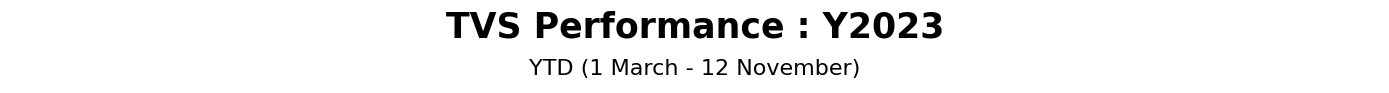

In [74]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

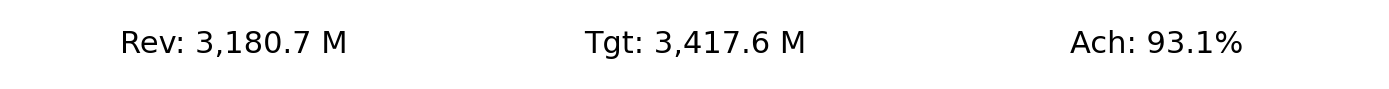

In [75]:
''' YTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(ytd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

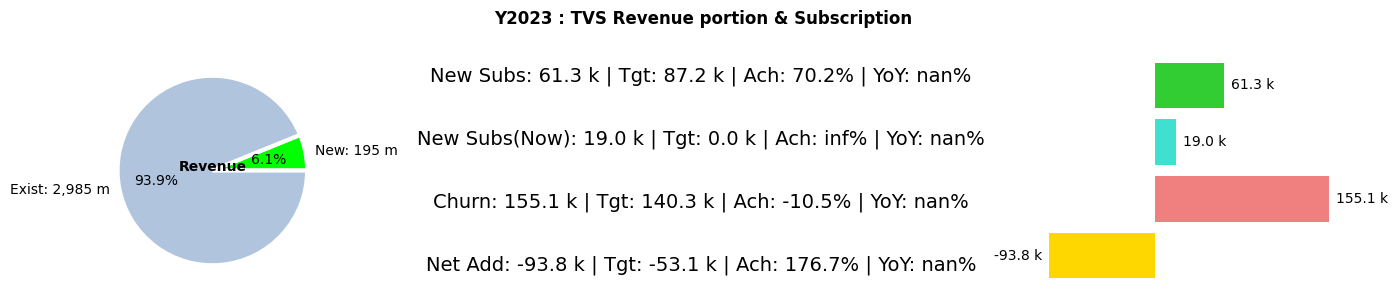

In [76]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Y{curr_yr} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(ytd_rev_new.sum()), unit_mb(ytd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(ytd_new_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_new_sub),',.1f')} k | Ach: {format(ytd_achv_new_sub,',.1%')} | YoY: {format(ytd_yoy_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(ytd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_new_sub_now),',.1f')} k | Ach: {format(ytd_achv_new_sub_now,',.1%')} | YoY: {format(ytd_yoy_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(ytd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_chrn_sub),',.1f')} k | Ach: {format(ytd_achv_chrn_sub,',.1%')} | YoY: {format(ytd_yoy_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(ytd_net_add),',.1f')} k | Tgt: {format(unit_k(ytd_tgt_net_add),',.1f')} k | Ach: {format(ytd_achv_net_add,',.1%')} | YoY: {format(ytd_yoy_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_ytd['METRIC_NAME'], width=unit_k(df_bar_h_ytd['VALUES']), color=df_bar_h_ytd['COLOR'])
# ax6.bar_label(bars, label_type='edge', padding=-45, fontweight='bold', fmt='%.1f k', color='white')
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

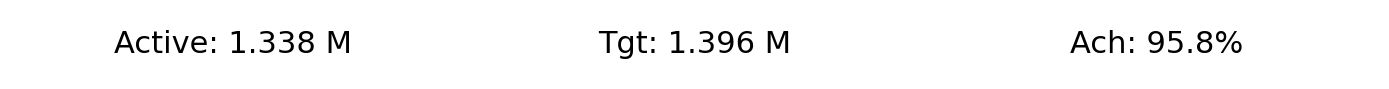

In [77]:
''' YTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(ytd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy_actv_sub,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [78]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_mth['%ACHV'] = np.where(df_mth['METRIC_NAME'].str.contains("Churn"), -((df_mth['ACT']/df_mth['TGT'])-1), df_mth['ACT']/df_mth['TGT']) 
df_mth['GAP'] = df_mth['ACT'] - df_mth['TGT']
df_mth['LAST_ACT'] = df_mth.groupby('METRIC_CD')['ACT'].shift()
df_mth['DIFF'] = df_mth['ACT'] - df_mth['LAST_ACT']
df_mth['%MOM'] = (df_mth['ACT'] / df_mth['LAST_ACT']) - 1

df_mth.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
145551,TB4S000500,TVS Active Subs,202309,September,N,1348901.0,1406501.0,0.959047,-57600.0,1357543.0,-8642.0,-0.006366
145582,TB4S000500,TVS Active Subs,202310,October,N,1340859.0,1399177.0,0.958320,-58318.0,1348901.0,-8042.0,-0.005962
145594,TB4S000500,TVS Active Subs,202311,November,N,1337542.0,1396291.0,0.957925,-58749.0,1340859.0,-3317.0,-0.002474


In [79]:
''' Pivot by KPIS '''

df_mth_agg = df_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_mth_agg.tail(3)

TM_KEY_MTH   MTH_DESC        ACT                                 \
METRIC_NAME                         ACTV_SUB CHRN_SUB         EXIST NEW_SUB   
6               202309  September  1348901.0  24752.0  3.408808e+08  8106.0   
7               202310    October  1340859.0  35021.0  3.332856e+08  7239.0   
8               202311   November  1337542.0  12991.0  7.340187e+07  2616.0   

                                                               ...      %MOM  \
METRIC_NAME NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM NEW_SUB_NOW  ...  CHRN_SUB   
6                 5787.0       968.0       1351.0      2657.0  ...  0.403732   
7                 5780.0       639.0        820.0      3354.0  ...  0.414876   
8                 2022.0       293.0        301.0      1164.0  ... -0.629051   

                                                                       \
METRIC_NAME     EXIST   NEW_SUB NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM   
6           -0.117355 -0.012427    -0.047564    0.245817    -0.002952   
7           -0.022281 -0.106958    -0.001210   -0.339876    -0.393042   
8           -0.779763 -0.638624    -0.650173   -0.541471    -0.632927   

                                                       
METRIC_NAME NEW_SUB_NOW   NET_ADD       NEW     TOTAL  
6              0.164840  0.766154  0.048787 -0.109020  
7              0.262326  0.668990 -0.290604 -0.035151  
8             -0.652952 -0.626557 -0.429548 -0.758171  

[3 rows x 79 columns]

In [80]:
''' MTD Values '''

day_cnt_curr_mth = len(df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth]['TM_KEY_DAY'].unique())
day_cnt_last_mth = len(df_day_agg[df_day_agg['TM_KEY_MTH']==last_mth]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_mth_rev = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['TOTAL'].sum()
last_mth_rev_new = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW'].sum()
last_mth_rev_exist = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['EXIST'].sum()
last_mth_actv_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['ACTV_SUB'].sum()
last_mth_chrn_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['CHRN_SUB'].sum()
last_mth_net_add = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NET_ADD'].sum()
last_mth_new_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB'].sum()
last_mth_new_sub_prem = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_PREM'].sum()
last_mth_new_sub_mid = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_MID'].sum()
last_mth_new_sub_mass = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_MASS'].sum()
last_mth_new_sub_now = df_mth_agg[df_mth_agg['TM_KEY_MTH']==last_mth]['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
mtd_rev = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['TOTAL'].sum()
mtd_tgt = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['TOTAL'].sum()
mtd_achv = mtd_rev / mtd_tgt
mtd_last_rev = (last_mth_rev / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom = (mtd_rev / mtd_last_rev) - 1
mtd_gap = mtd_rev - mtd_last_rev

''' NEW : Values '''
mtd_rev_new = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW'].sum()
mtd_tgt_new = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW'].sum()
mtd_achv_new = mtd_rev_new / mtd_tgt_new
mtd_last_rev_new = (last_mth_rev_new / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new = (mtd_rev_new / mtd_last_rev_new) - 1
mtd_gap_new = mtd_rev_new - mtd_last_rev_new

''' EXIST : Values '''
mtd_rev_exist = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['EXIST'].sum()
mtd_tgt_exist = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['EXIST'].sum()
mtd_achv_exist = mtd_rev_exist / mtd_tgt_exist
mtd_last_rev_exist = (last_mth_rev_exist / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_exist = (mtd_rev_exist / mtd_last_rev_exist) - 1
mtd_gap_exist = mtd_rev_exist - mtd_last_rev_exist

''' ACTV_SUB : Values '''
mtd_actv_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['ACTV_SUB'].sum()
mtd_tgt_actv_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['ACTV_SUB'].sum()
mtd_achv_actv_sub = mtd_actv_sub / mtd_tgt_actv_sub
mtd_last_actv_sub = (last_mth_actv_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_actv_sub = (mtd_actv_sub / mtd_last_actv_sub) - 1
mtd_gap_actv_sub = mtd_actv_sub - mtd_last_actv_sub

''' CHRN_SUB : Values '''
mtd_chrn_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['CHRN_SUB'].sum()
mtd_tgt_chrn_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['CHRN_SUB'].sum()
mtd_achv_chrn_sub = -((mtd_chrn_sub / mtd_tgt_chrn_sub) - 1)
mtd_last_chrn_sub = (last_mth_chrn_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_chrn_sub = (mtd_chrn_sub / mtd_last_chrn_sub) - 1
mtd_gap_chrn_sub = mtd_chrn_sub - mtd_last_chrn_sub

''' NET_ADD : Values '''
mtd_net_add = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NET_ADD'].sum()
mtd_tgt_net_add = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NET_ADD'].sum()
mtd_achv_net_add = mtd_net_add / mtd_tgt_net_add
mtd_last_net_add = (last_mth_net_add / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_net_add = (mtd_net_add / mtd_last_net_add) - 1
mtd_gap_net_add = mtd_net_add - mtd_last_net_add

''' NEW_SUB : Values '''
mtd_new_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB'].sum()
mtd_tgt_new_sub = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB'].sum()
mtd_achv_new_sub = mtd_new_sub / mtd_tgt_new_sub
mtd_last_new_sub = (last_mth_new_sub / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub = (mtd_new_sub / mtd_last_new_sub) - 1
mtd_gap_new_sub = mtd_new_sub - mtd_last_new_sub

''' NEW_SUB_PREM : Values '''
mtd_new_sub_prem = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_PREM'].sum()
mtd_tgt_new_sub_prem = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_PREM'].sum()
mtd_achv_new_sub_prem = mtd_new_sub_prem / mtd_tgt_new_sub_prem
mtd_last_new_sub_prem = (last_mth_new_sub_prem / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_prem = (mtd_new_sub_prem / mtd_last_new_sub_prem) - 1
mtd_gap_new_sub_prem = mtd_new_sub_prem - mtd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
mtd_new_sub_mid = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_MID'].sum()
mtd_tgt_new_sub_mid = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_MID'].sum()
mtd_achv_new_sub_mid = mtd_new_sub_mid / mtd_tgt_new_sub_mid
mtd_last_new_sub_mid = (last_mth_new_sub_mid / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_mid = (mtd_new_sub_mid / mtd_last_new_sub_mid) - 1
mtd_gap_new_sub_mid = mtd_new_sub_mid - mtd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
mtd_new_sub_mass = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_MASS'].sum()
mtd_tgt_new_sub_mass = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_MASS'].sum()
mtd_achv_new_sub_mass = mtd_new_sub_mass / mtd_tgt_new_sub_mass
mtd_last_new_sub_mass = (last_mth_new_sub_mass / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_mass = (mtd_new_sub_mass / mtd_last_new_sub_mass) - 1
mtd_gap_new_sub_mass = mtd_new_sub_mass - mtd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
mtd_new_sub_now = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT']['NEW_SUB_NOW'].sum()
mtd_tgt_new_sub_now = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['TGT']['NEW_SUB_NOW'].sum()
mtd_achv_new_sub_now = mtd_new_sub_now / mtd_tgt_new_sub_now
mtd_last_new_sub_now = (last_mth_new_sub_now / day_cnt_last_mth) * day_cnt_curr_mth
mtd_mom_new_sub_now = (mtd_new_sub_now / mtd_last_new_sub_now) - 1
mtd_gap_new_sub_now = mtd_new_sub_now - mtd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\866280400.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_new_sub_prem = mtd_new_sub_prem / mtd_tgt_new_sub_prem
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\866280400.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_new_sub_mid = mtd_new_sub_mid / mtd_tgt_new_sub_mid
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\866280400.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_new_sub_mass = mtd_new_sub_mass / mtd_tgt_new_sub_mass
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\866280400.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_achv_new_sub_now = mtd_new_sub_now / mtd_tgt_new_sub_now


In [81]:
''' MTD BarH Dataframe'''

df_bar_h_mtd = df_mth_agg[df_mth_agg['TM_KEY_MTH']==curr_mth]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_mtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_mtd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_mtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_mtd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_mtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_mtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_mtd = df_bar_h_mtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_mtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,-10375.0,gold,4
2,CHRN_SUB,12991.0,lightcoral,3
1,NEW_SUB_NOW,1164.0,turquoise,2
0,NEW_SUB,2616.0,limegreen,1


In [82]:
''' Month Chart Values '''

x_mth = df_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' TOTAL : Values '''
y_mth_act = df_mth_agg['ACT']['TOTAL']
y_mth_tgt = df_mth_agg['TGT']['TOTAL']
y_mth_achv = df_mth_agg['%ACHV']['TOTAL']
y_mth_gap = df_mth_agg['GAP']['TOTAL']
y_mth_diff = df_mth_agg['DIFF']['TOTAL']
y_mth_last_act = df_mth_agg['LAST_ACT']['TOTAL']
y_mth_mom = df_mth_agg['%MOM']['TOTAL']

''' NEW : Values '''
y_mth_act_new = df_mth_agg['ACT']['NEW']
y_mth_tgt_new = df_mth_agg['TGT']['NEW']
y_mth_achv_new = df_mth_agg['%ACHV']['NEW']
y_mth_gap_new = df_mth_agg['GAP']['NEW']
y_mth_diff_new = df_mth_agg['DIFF']['NEW']
y_mth_last_act_new = df_mth_agg['LAST_ACT']['NEW']
y_mth_mom_new = df_mth_agg['%MOM']['NEW']

''' EXIST : Values '''
y_mth_act_exist = df_mth_agg['ACT']['EXIST']
y_mth_tgt_exist = df_mth_agg['TGT']['EXIST']
y_mth_achv_exist = df_mth_agg['%ACHV']['EXIST']
y_mth_gap_exist = df_mth_agg['GAP']['EXIST']
y_mth_diff_exist = df_mth_agg['DIFF']['EXIST']
y_mth_last_act_exist = df_mth_agg['LAST_ACT']['EXIST']
y_mth_mom_exist = df_mth_agg['%MOM']['EXIST']

''' ACTV_SUB : Values '''
y_mth_act_actv_sub = df_mth_agg['ACT']['ACTV_SUB']
y_mth_tgt_actv_sub = df_mth_agg['TGT']['ACTV_SUB']
y_mth_achv_actv_sub = df_mth_agg['%ACHV']['ACTV_SUB']
y_mth_gap_actv_sub = df_mth_agg['GAP']['ACTV_SUB']
y_mth_diff_actv_sub = df_mth_agg['DIFF']['ACTV_SUB']
y_mth_last_act_actv_sub = df_mth_agg['LAST_ACT']['ACTV_SUB']
y_mth_mom_actv_sub = df_mth_agg['%MOM']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_mth_act_chrn_sub = df_mth_agg['ACT']['CHRN_SUB']
y_mth_tgt_chrn_sub = df_mth_agg['TGT']['CHRN_SUB']
y_mth_achv_chrn_sub = df_mth_agg['%ACHV']['CHRN_SUB']
y_mth_gap_chrn_sub = df_mth_agg['GAP']['CHRN_SUB']
y_mth_diff_chrn_sub = df_mth_agg['DIFF']['CHRN_SUB']
y_mth_last_act_chrn_sub = df_mth_agg['LAST_ACT']['CHRN_SUB']
y_mth_mom_chrn_sub = df_mth_agg['%MOM']['CHRN_SUB']

''' NET_ADD : Values '''
y_mth_act_net_add = df_mth_agg['ACT']['NET_ADD']
y_mth_tgt_net_add = df_mth_agg['TGT']['NET_ADD']
y_mth_achv_net_add = df_mth_agg['%ACHV']['NET_ADD']
y_mth_gap_net_add = df_mth_agg['GAP']['NET_ADD']
y_mth_diff_net_add = df_mth_agg['DIFF']['NET_ADD']
y_mth_last_act_net_add = df_mth_agg['LAST_ACT']['NET_ADD']
y_mth_mom_net_add = df_mth_agg['%MOM']['NET_ADD']

''' NEW_SUB : Values '''
y_mth_act_new_sub = df_mth_agg['ACT']['NEW_SUB']
y_mth_tgt_new_sub = df_mth_agg['TGT']['NEW_SUB']
y_mth_achv_new_sub = df_mth_agg['%ACHV']['NEW_SUB']
y_mth_gap_new_sub = df_mth_agg['GAP']['NEW_SUB']
y_mth_diff_new_sub = df_mth_agg['DIFF']['NEW_SUB']
y_mth_last_act_new_sub = df_mth_agg['LAST_ACT']['NEW_SUB']
y_mth_mom_new_sub = df_mth_agg['%MOM']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_mth_act_new_sub_prem = df_mth_agg['ACT']['NEW_SUB_PREM']
y_mth_tgt_new_sub_prem = df_mth_agg['TGT']['NEW_SUB_PREM']
y_mth_achv_new_sub_prem = df_mth_agg['%ACHV']['NEW_SUB_PREM']
y_mth_gap_new_sub_prem = df_mth_agg['GAP']['NEW_SUB_PREM']
y_mth_diff_new_sub_prem = df_mth_agg['DIFF']['NEW_SUB_PREM']
y_mth_last_act_new_sub_prem = df_mth_agg['LAST_ACT']['NEW_SUB_PREM']
y_mth_mom_new_sub_prem = df_mth_agg['%MOM']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_mth_act_new_sub_mid = df_mth_agg['ACT']['NEW_SUB_MID']
y_mth_tgt_new_sub_mid = df_mth_agg['TGT']['NEW_SUB_MID']
y_mth_achv_new_sub_mid = df_mth_agg['%ACHV']['NEW_SUB_MID']
y_mth_gap_new_sub_mid = df_mth_agg['GAP']['NEW_SUB_MID']
y_mth_diff_new_sub_mid = df_mth_agg['DIFF']['NEW_SUB_MID']
y_mth_last_act_new_sub_mid = df_mth_agg['LAST_ACT']['NEW_SUB_MID']
y_mth_mom_new_sub_mid = df_mth_agg['%MOM']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_mth_act_new_sub_mass = df_mth_agg['ACT']['NEW_SUB_MASS']
y_mth_tgt_new_sub_mass = df_mth_agg['TGT']['NEW_SUB_MASS']
y_mth_achv_new_sub_mass = df_mth_agg['%ACHV']['NEW_SUB_MASS']
y_mth_gap_new_sub_mass = df_mth_agg['GAP']['NEW_SUB_MASS']
y_mth_diff_new_sub_mass = df_mth_agg['DIFF']['NEW_SUB_MASS']
y_mth_last_act_new_sub_mass = df_mth_agg['LAST_ACT']['NEW_SUB_MASS']
y_mth_mom_new_sub_mass = df_mth_agg['%MOM']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_mth_act_new_sub_now = df_mth_agg['ACT']['NEW_SUB_NOW']
y_mth_tgt_new_sub_now = df_mth_agg['TGT']['NEW_SUB_NOW']
y_mth_achv_new_sub_now = df_mth_agg['%ACHV']['NEW_SUB_NOW']
y_mth_gap_new_sub_now = df_mth_agg['GAP']['NEW_SUB_NOW']
y_mth_diff_new_sub_now = df_mth_agg['DIFF']['NEW_SUB_NOW']
y_mth_last_act_new_sub_now = df_mth_agg['LAST_ACT']['NEW_SUB_NOW']
y_mth_mom_new_sub_now = df_mth_agg['%MOM']['NEW_SUB_NOW']

### MTH : Visualizations

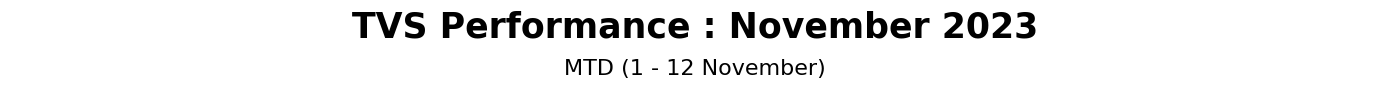

In [83]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

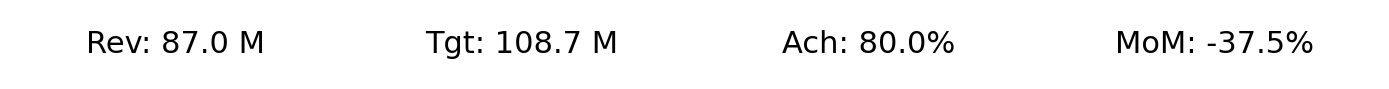

In [84]:
''' MTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(mtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

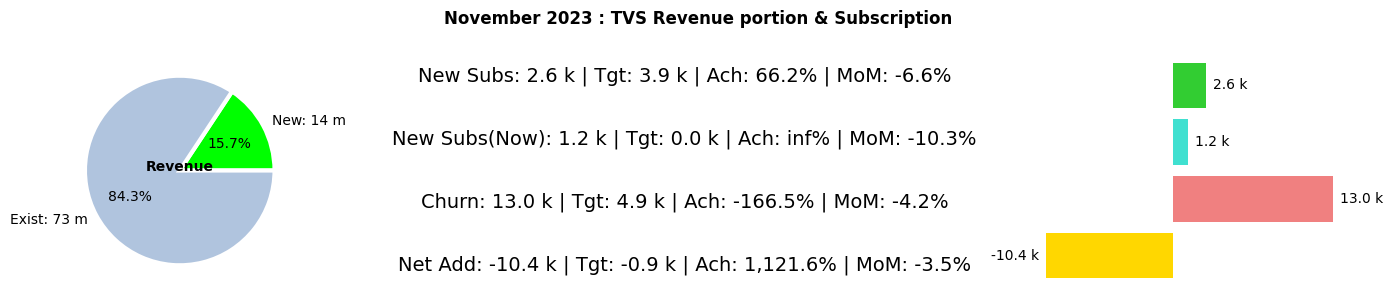

In [85]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'{curr_mth_desc} {curr_yr} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(mtd_rev_new.sum()), unit_mb(mtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(mtd_new_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_new_sub),',.1f')} k | Ach: {format(mtd_achv_new_sub,',.1%')} | MoM: {format(mtd_mom_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(mtd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_new_sub_now),',.1f')} k | Ach: {format(mtd_achv_new_sub_now,',.1%')} | MoM: {format(mtd_mom_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(mtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_chrn_sub),',.1f')} k | Ach: {format(mtd_achv_chrn_sub,',.1%')} | MoM: {format(mtd_mom_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(mtd_net_add),',.1f')} k | Tgt: {format(unit_k(mtd_tgt_net_add),',.1f')} k | Ach: {format(mtd_achv_net_add,',.1%')} | MoM: {format(mtd_mom_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_mtd['METRIC_NAME'], width=unit_k(df_bar_h_mtd['VALUES']), color=df_bar_h_mtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

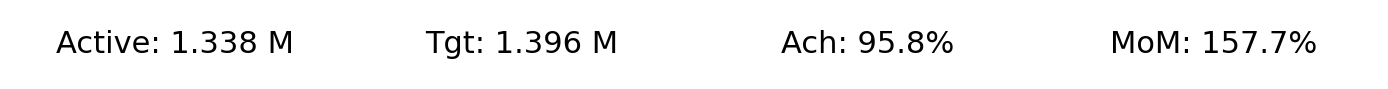

In [86]:
''' MTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(mtd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

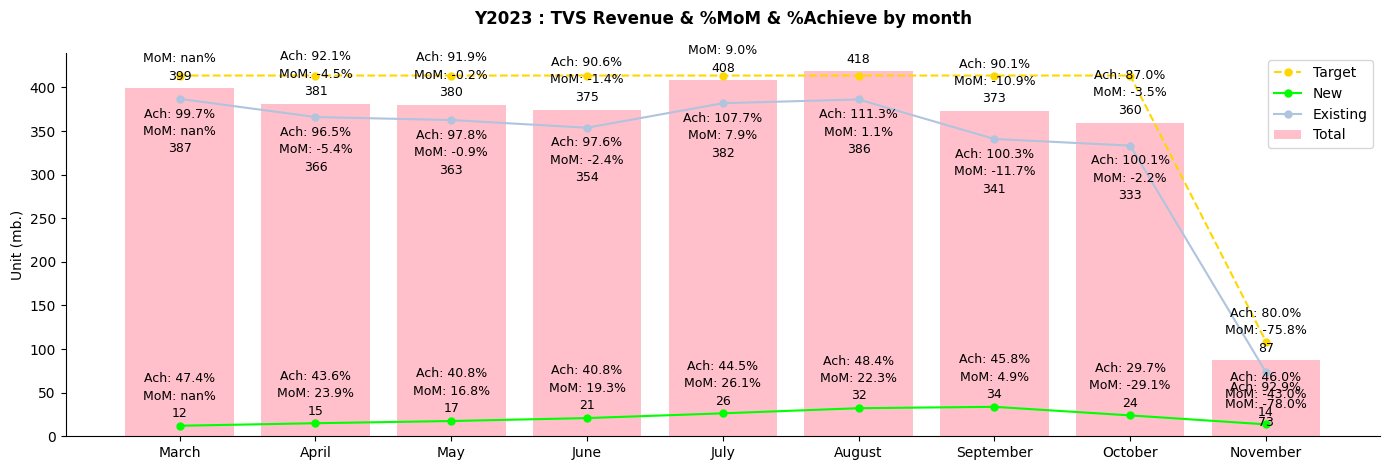

In [87]:
''' Revenue & MoM & Achieve by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Revenue & %MoM & %Achieve by month\n", weight='bold')

plt.bar(x_mth_axis, unit_mb(y_mth_act), label='Total', color='pink')

plt.plot(x_mth_axis, unit_mb(y_mth_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_mth_axis, unit_mb(y_mth_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')

for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+50), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+30), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+10), ha='center', fontsize=9)

    plt.annotate(f"Ach: {format(y_mth_achv_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+50), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_new[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+30), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_new[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_new[i])+10), ha='center', fontsize=9)
    
    plt.annotate(f"Ach: {format(y_mth_achv_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-10), ha='center', va='top', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_exist[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-30), ha='center', va='top', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_exist[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_exist[i])-50), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

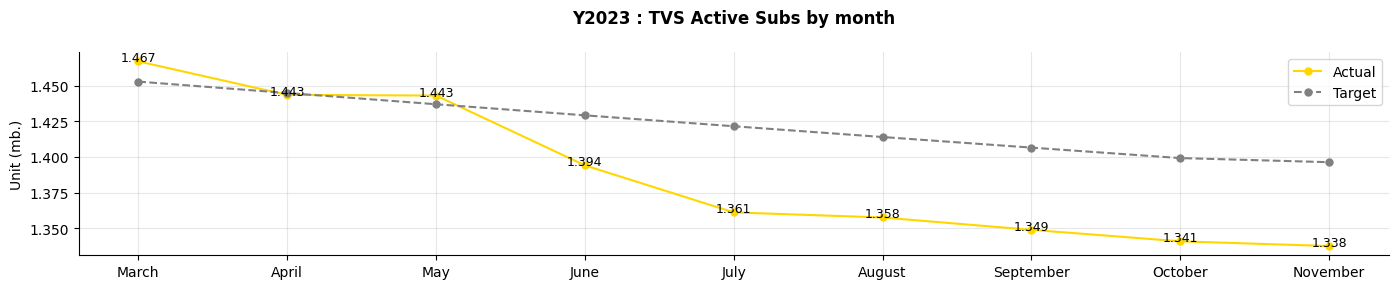

In [88]:
''' Active Subs by month '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : {v_product} Active Subs by month\n", weight='bold')

plt.plot(x_mth_axis, unit_mb(y_mth_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
plt.plot(x_mth_axis, unit_mb(y_mth_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_mth_axis:
    plt.annotate(f"Ach: {format(y_mth_achv_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.6), ha='center', fontsize=9)
    plt.annotate(f"MoM: {format(y_mth_mom_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])+0.3), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_actv_sub[i]),',.3f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_actv_sub[i])), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

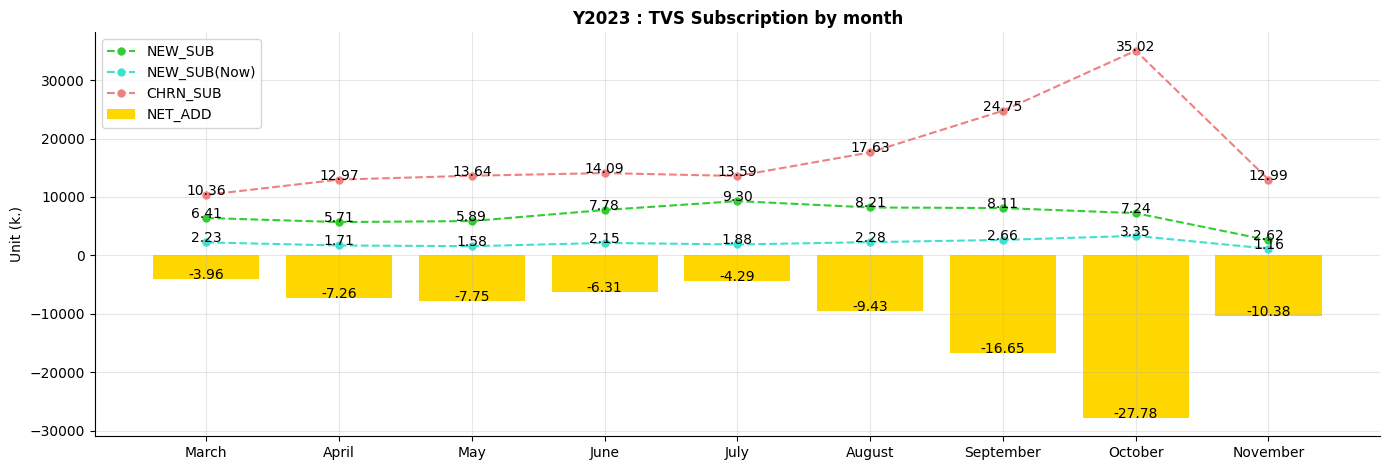

In [89]:
''' Subscription by month '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Subscription by month", weight='bold')

plt.plot(x_mth_axis, y_mth_act_new_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB', color='limegreen')
plt.plot(x_mth_axis, y_mth_act_new_sub_now, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB(Now)', color='turquoise')
plt.plot(x_mth_axis, y_mth_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_mth_axis, y_mth_act_net_add, label='NET_ADD', color='gold')
for i in x_mth_axis:
    plt.annotate(format(unit_k(y_mth_act_new_sub[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_new_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_new_sub_now[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_new_sub_now[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_chrn_sub[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_chrn_sub[i]), ha='center')
    plt.annotate(format(unit_k(y_mth_act_net_add[i]),',.2f'), xy=(x_mth_axis[i], y_mth_act_net_add[i]), ha='center')

plt.ylabel('Unit (k.)')
plt.xticks(x_mth_axis, x_mth)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [90]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT', 'TGT']]
df_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

''' Aggregation '''
df_wk['%ACHV'] = np.where(df_wk['METRIC_NAME'].str.contains("Churn"), -((df_wk['ACT']/df_wk['TGT'])-1), df_wk['ACT']/df_wk['TGT']) 
df_wk['GAP'] = df_wk['ACT'] - df_wk['TGT']
df_wk['LAST_ACT'] = df_wk.groupby('METRIC_CD')['ACT'].shift()
df_wk['DIFF'] = df_wk['ACT'] - df_wk['LAST_ACT']
df_wk['%WOW'] = (df_wk['ACT'] / df_wk['LAST_ACT']) - 1

df_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%WOW
145580,TB4S000500,TVS Active Subs,2023043,43,N,1340776.0,1399650.0,0.957937,-58874.0,1342465.0,-1689.0,-0.001258
145587,TB4S000500,TVS Active Subs,2023044,44,N,1339385.0,1397974.0,0.958090,-58589.0,1340776.0,-1391.0,-0.001037
145594,TB4S000500,TVS Active Subs,2023045,45,N,1337542.0,1396291.0,0.957925,-58749.0,1339385.0,-1843.0,-0.001376


In [91]:
''' Pivot by KPIS '''

df_wk_agg = df_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_wk_agg.tail(3)

TM_KEY_WK WK_LABEL        ACT                                 \
METRIC_NAME                      ACTV_SUB CHRN_SUB         EXIST NEW_SUB   
34            2023043       43  1340776.0   7773.0  4.382663e+07  1387.0   
35            2023044       44  1339385.0   8559.0  1.635719e+08  1506.0   
36            2023045       45  1337542.0   5124.0  3.782977e+07  1442.0   

                                                               ...      %WOW  \
METRIC_NAME NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM NEW_SUB_NOW  ...  CHRN_SUB   
34                1135.0        95.0        157.0       843.0  ...  0.002968   
35                1143.0       146.0        217.0       749.0  ...  0.101119   
36                1133.0       159.0        150.0       664.0  ... -0.401332   

                                                                       \
METRIC_NAME     EXIST   NEW_SUB NEW_SUB_MASS NEW_SUB_MID NEW_SUB_PREM   
34          -0.329898 -0.134207    -0.139500   -0.188034    -0.054217   
35           2.732248  0.085797     0.007048    0.536842     0.382166   
36          -0.768727 -0.042497    -0.008749    0.089041    -0.308756   

                                                       
METRIC_NAME NEW_SUB_NOW   NET_ADD       NEW     TOTAL  
34             0.368506  0.038712 -0.298139 -0.326849  
35            -0.111507  0.104447 -0.042047  2.503348  
36            -0.113485 -0.477953  0.929320 -0.725503  

[3 rows x 79 columns]

In [92]:
''' WTD Values '''

day_cnt_curr_wk = len(df_day_agg[df_day_agg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].unique())
day_cnt_last_wk = len(df_day_agg[df_day_agg['TM_KEY_WK']==last_wk]['TM_KEY_DAY'].unique())

''' Last Period : Values '''
last_wk_rev = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['TOTAL'].sum()
last_wk_rev_new = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW'].sum()
last_wk_rev_exist = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['EXIST'].sum()
last_wk_actv_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['ACTV_SUB'].sum()
last_wk_chrn_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['CHRN_SUB'].sum()
last_wk_net_add = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NET_ADD'].sum()
last_wk_new_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB'].sum()
last_wk_new_sub_prem = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_PREM'].sum()
last_wk_new_sub_mid = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_MID'].sum()
last_wk_new_sub_mass = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_MASS'].sum()
last_wk_new_sub_now = df_wk_agg[df_wk_agg['TM_KEY_WK']==last_wk]['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
wtd_rev = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['TOTAL'].sum()
wtd_tgt = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['TOTAL'].sum()
wtd_achv = wtd_rev / wtd_tgt
wtd_last_rev = (last_wk_rev / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow = (wtd_rev / wtd_last_rev) - 1
wtd_gap = wtd_rev - wtd_last_rev

''' NEW : Values '''
wtd_rev_new = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW'].sum()
wtd_tgt_new = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW'].sum()
wtd_achv_new = wtd_rev_new / wtd_tgt_new
wtd_last_rev_new = (last_wk_rev_new / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new = (wtd_rev_new / wtd_last_rev_new) - 1
wtd_gap_new = wtd_rev_new - wtd_last_rev_new

''' EXIST : Values '''
wtd_rev_exist = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['EXIST'].sum()
wtd_tgt_exist = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['EXIST'].sum()
wtd_achv_exist = wtd_rev_exist / wtd_tgt_exist
wtd_last_rev_exist = (last_wk_rev_exist / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_exist = (wtd_rev_exist / wtd_last_rev_exist) - 1
wtd_gap_exist = wtd_rev_exist - wtd_last_rev_exist

''' ACTV_SUB : Values '''
wtd_actv_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['ACTV_SUB'].sum()
wtd_tgt_actv_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['ACTV_SUB'].sum()
wtd_achv_actv_sub = wtd_actv_sub / wtd_tgt_actv_sub
wtd_last_actv_sub = (last_wk_actv_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_actv_sub = (wtd_actv_sub / wtd_last_actv_sub) - 1
wtd_gap_actv_sub = wtd_actv_sub - wtd_last_actv_sub

''' CHRN_SUB : Values '''
wtd_chrn_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['CHRN_SUB'].sum()
wtd_tgt_chrn_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['CHRN_SUB'].sum()
wtd_achv_chrn_sub = -((wtd_chrn_sub / wtd_tgt_chrn_sub) - 1)
wtd_last_chrn_sub = (last_wk_chrn_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_chrn_sub = (wtd_chrn_sub / wtd_last_chrn_sub) - 1
wtd_gap_chrn_sub = wtd_chrn_sub - wtd_last_chrn_sub

''' NET_ADD : Values '''
wtd_net_add = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NET_ADD'].sum()
wtd_tgt_net_add = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NET_ADD'].sum()
wtd_achv_net_add = wtd_net_add / wtd_tgt_net_add
wtd_last_net_add = (last_wk_net_add / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_net_add = (wtd_net_add / wtd_last_net_add) - 1
wtd_gap_net_add = wtd_net_add - wtd_last_net_add

''' NEW_SUB : Values '''
wtd_new_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB'].sum()
wtd_tgt_new_sub = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB'].sum()
wtd_achv_new_sub = wtd_new_sub / wtd_tgt_new_sub
wtd_last_new_sub = (last_wk_new_sub / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub = (wtd_new_sub / wtd_last_new_sub) - 1
wtd_gap_new_sub = wtd_new_sub - wtd_last_new_sub

''' NEW_SUB_PREM : Values '''
wtd_new_sub_prem = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_PREM'].sum()
wtd_tgt_new_sub_prem = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_PREM'].sum()
wtd_achv_new_sub_prem = wtd_new_sub_prem / wtd_tgt_new_sub_prem
wtd_last_new_sub_prem = (last_wk_new_sub_prem / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_prem = (wtd_new_sub_prem / wtd_last_new_sub_prem) - 1
wtd_gap_new_sub_prem = wtd_new_sub_prem - wtd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
wtd_new_sub_mid = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_MID'].sum()
wtd_tgt_new_sub_mid = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_MID'].sum()
wtd_achv_new_sub_mid = wtd_new_sub_mid / wtd_tgt_new_sub_mid
wtd_last_new_sub_mid = (last_wk_new_sub_mid / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_mid = (wtd_new_sub_mid / wtd_last_new_sub_mid) - 1
wtd_gap_new_sub_mid = wtd_new_sub_mid - wtd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
wtd_new_sub_mass = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_MASS'].sum()
wtd_tgt_new_sub_mass = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_MASS'].sum()
wtd_achv_new_sub_mass = wtd_new_sub_mass / wtd_tgt_new_sub_mass
wtd_last_new_sub_mass = (last_wk_new_sub_mass / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_mass = (wtd_new_sub_mass / wtd_last_new_sub_mass) - 1
wtd_gap_new_sub_mass = wtd_new_sub_mass - wtd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
wtd_new_sub_now = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT']['NEW_SUB_NOW'].sum()
wtd_tgt_new_sub_now = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['TGT']['NEW_SUB_NOW'].sum()
wtd_achv_new_sub_now = wtd_new_sub_now / wtd_tgt_new_sub_now
wtd_last_new_sub_now = (last_wk_new_sub_now / day_cnt_last_wk) * day_cnt_curr_wk
wtd_wow_new_sub_now = (wtd_new_sub_now / wtd_last_new_sub_now) - 1
wtd_gap_new_sub_now = wtd_new_sub_now - wtd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\532444306.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  wtd_achv_new_sub_prem = wtd_new_sub_prem / wtd_tgt_new_sub_prem
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\532444306.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  wtd_achv_new_sub_mid = wtd_new_sub_mid / wtd_tgt_new_sub_mid
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\532444306.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  wtd_achv_new_sub_mass = wtd_new_sub_mass / wtd_tgt_new_sub_mass
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\532444306.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  wtd_achv_new_sub_now = wtd_new_sub_now / wtd_tgt_new_sub_now


In [93]:
''' WTD BarH Dataframe'''

df_bar_h_wtd = df_wk_agg[df_wk_agg['TM_KEY_WK']==curr_wk]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_wtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_wtd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_wtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_wtd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_wtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_wtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_wtd = df_bar_h_wtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_wtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,-3682.0,gold,4
2,CHRN_SUB,5124.0,lightcoral,3
1,NEW_SUB_NOW,664.0,turquoise,2
0,NEW_SUB,1442.0,limegreen,1


In [94]:
''' Week Chart Values '''

x_wk = df_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' TOTAL : Values '''
y_wk_act = df_wk_agg['ACT']['TOTAL']
y_wk_tgt = df_wk_agg['TGT']['TOTAL']
y_wk_achv = df_wk_agg['%ACHV']['TOTAL']
y_wk_gap = df_wk_agg['GAP']['TOTAL']
y_wk_diff = df_wk_agg['DIFF']['TOTAL']
y_wk_last_act = df_wk_agg['LAST_ACT']['TOTAL']
y_wk_wow = df_wk_agg['%WOW']['TOTAL']

''' NEW : Values '''
y_wk_act_new = df_wk_agg['ACT']['NEW']
y_wk_tgt_new = df_wk_agg['TGT']['NEW']
y_wk_achv_new = df_wk_agg['%ACHV']['NEW']
y_wk_gap_new = df_wk_agg['GAP']['NEW']
y_wk_diff_new = df_wk_agg['DIFF']['NEW']
y_wk_last_act_new = df_wk_agg['LAST_ACT']['NEW']
y_wk_wow_new = df_wk_agg['%WOW']['NEW']

''' EXIST : Values '''
y_wk_act_exist = df_wk_agg['ACT']['EXIST']
y_wk_tgt_exist = df_wk_agg['TGT']['EXIST']
y_wk_achv_exist = df_wk_agg['%ACHV']['EXIST']
y_wk_gap_exist = df_wk_agg['GAP']['EXIST']
y_wk_diff_exist = df_wk_agg['DIFF']['EXIST']
y_wk_last_act_exist = df_wk_agg['LAST_ACT']['EXIST']
y_wk_wow_exist = df_wk_agg['%WOW']['EXIST']

''' ACTV_SUB : Values '''
y_wk_act_actv_sub = df_wk_agg['ACT']['ACTV_SUB']
y_wk_tgt_actv_sub = df_wk_agg['TGT']['ACTV_SUB']
y_wk_achv_actv_sub = df_wk_agg['%ACHV']['ACTV_SUB']
y_wk_gap_actv_sub = df_wk_agg['GAP']['ACTV_SUB']
y_wk_diff_actv_sub = df_wk_agg['DIFF']['ACTV_SUB']
y_wk_last_act_actv_sub = df_wk_agg['LAST_ACT']['ACTV_SUB']
y_wk_wow_actv_sub = df_wk_agg['%WOW']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_wk_act_chrn_sub = df_wk_agg['ACT']['CHRN_SUB']
y_wk_tgt_chrn_sub = df_wk_agg['TGT']['CHRN_SUB']
y_wk_achv_chrn_sub = df_wk_agg['%ACHV']['CHRN_SUB']
y_wk_gap_chrn_sub = df_wk_agg['GAP']['CHRN_SUB']
y_wk_diff_chrn_sub = df_wk_agg['DIFF']['CHRN_SUB']
y_wk_last_act_chrn_sub = df_wk_agg['LAST_ACT']['CHRN_SUB']
y_wk_wow_chrn_sub = df_wk_agg['%WOW']['CHRN_SUB']

''' NET_ADD : Values '''
y_wk_act_net_add = df_wk_agg['ACT']['NET_ADD']
y_wk_tgt_net_add = df_wk_agg['TGT']['NET_ADD']
y_wk_achv_net_add = df_wk_agg['%ACHV']['NET_ADD']
y_wk_gap_net_add = df_wk_agg['GAP']['NET_ADD']
y_wk_diff_net_add = df_wk_agg['DIFF']['NET_ADD']
y_wk_last_act_net_add = df_wk_agg['LAST_ACT']['NET_ADD']
y_wk_wow_net_add = df_wk_agg['%WOW']['NET_ADD']

''' NEW_SUB : Values '''
y_wk_act_new_sub = df_wk_agg['ACT']['NEW_SUB']
y_wk_tgt_new_sub = df_wk_agg['TGT']['NEW_SUB']
y_wk_achv_new_sub = df_wk_agg['%ACHV']['NEW_SUB']
y_wk_gap_new_sub = df_wk_agg['GAP']['NEW_SUB']
y_wk_diff_new_sub = df_wk_agg['DIFF']['NEW_SUB']
y_wk_last_act_new_sub = df_wk_agg['LAST_ACT']['NEW_SUB']
y_wk_wow_new_sub = df_wk_agg['%WOW']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_wk_act_new_sub_prem = df_wk_agg['ACT']['NEW_SUB_PREM']
y_wk_tgt_new_sub_prem = df_wk_agg['TGT']['NEW_SUB_PREM']
y_wk_achv_new_sub_prem = df_wk_agg['%ACHV']['NEW_SUB_PREM']
y_wk_gap_new_sub_prem = df_wk_agg['GAP']['NEW_SUB_PREM']
y_wk_diff_new_sub_prem = df_wk_agg['DIFF']['NEW_SUB_PREM']
y_wk_last_act_new_sub_prem = df_wk_agg['LAST_ACT']['NEW_SUB_PREM']
y_wk_wow_new_sub_prem = df_wk_agg['%WOW']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_wk_act_new_sub_mid = df_wk_agg['ACT']['NEW_SUB_MID']
y_wk_tgt_new_sub_mid = df_wk_agg['TGT']['NEW_SUB_MID']
y_wk_achv_new_sub_mid = df_wk_agg['%ACHV']['NEW_SUB_MID']
y_wk_gap_new_sub_mid = df_wk_agg['GAP']['NEW_SUB_MID']
y_wk_diff_new_sub_mid = df_wk_agg['DIFF']['NEW_SUB_MID']
y_wk_last_act_new_sub_mid = df_wk_agg['LAST_ACT']['NEW_SUB_MID']
y_wk_wow_new_sub_mid = df_wk_agg['%WOW']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_wk_act_new_sub_mass = df_wk_agg['ACT']['NEW_SUB_MASS']
y_wk_tgt_new_sub_mass = df_wk_agg['TGT']['NEW_SUB_MASS']
y_wk_achv_new_sub_mass = df_wk_agg['%ACHV']['NEW_SUB_MASS']
y_wk_gap_new_sub_mass = df_wk_agg['GAP']['NEW_SUB_MASS']
y_wk_diff_new_sub_mass = df_wk_agg['DIFF']['NEW_SUB_MASS']
y_wk_last_act_new_sub_mass = df_wk_agg['LAST_ACT']['NEW_SUB_MASS']
y_wk_wow_new_sub_mass = df_wk_agg['%WOW']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_wk_act_new_sub_now = df_wk_agg['ACT']['NEW_SUB_NOW']
y_wk_tgt_new_sub_now = df_wk_agg['TGT']['NEW_SUB_NOW']
y_wk_achv_new_sub_now = df_wk_agg['%ACHV']['NEW_SUB_NOW']
y_wk_gap_new_sub_now = df_wk_agg['GAP']['NEW_SUB_NOW']
y_wk_diff_new_sub_now = df_wk_agg['DIFF']['NEW_SUB_NOW']
y_wk_last_act_new_sub_now = df_wk_agg['LAST_ACT']['NEW_SUB_NOW']
y_wk_wow_new_sub_now = df_wk_agg['%WOW']['NEW_SUB_NOW']

### WK : Visualizations

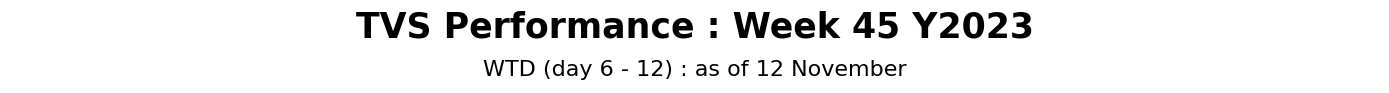

In [95]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

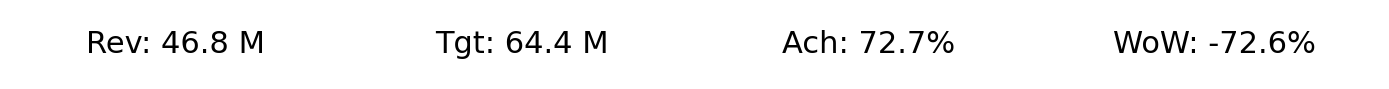

In [96]:
''' WTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(wtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

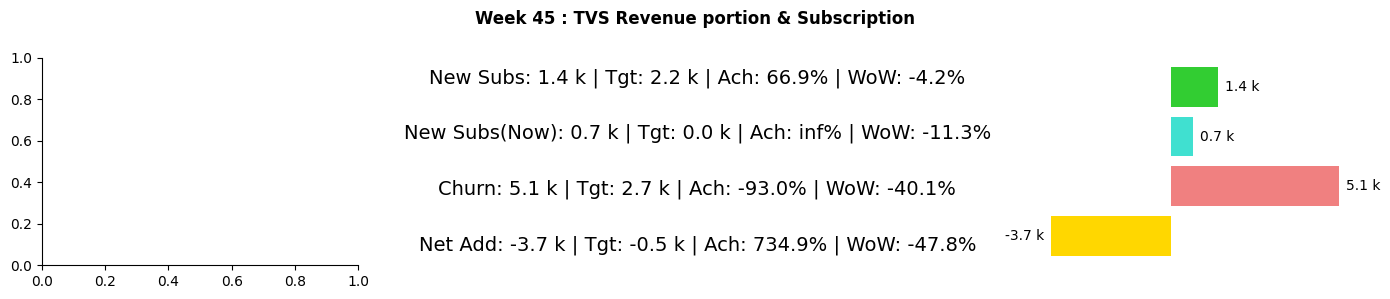

In [97]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Week {curr_wk_label} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

# ''' ax1 '''
# y = np.array([unit_mb(wtd_rev_new.sum()), unit_mb(wtd_rev_exist.sum())])
# mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
# mycolors = ["lime", "lightsteelblue"]
# ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
# ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(wtd_new_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_new_sub),',.1f')} k | Ach: {format(wtd_achv_new_sub,',.1%')} | WoW: {format(wtd_wow_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(wtd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_new_sub_now),',.1f')} k | Ach: {format(wtd_achv_new_sub_now,',.1%')} | WoW: {format(wtd_wow_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(wtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_chrn_sub),',.1f')} k | Ach: {format(wtd_achv_chrn_sub,',.1%')} | WoW: {format(wtd_wow_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(wtd_net_add),',.1f')} k | Tgt: {format(unit_k(wtd_tgt_net_add),',.1f')} k | Ach: {format(wtd_achv_net_add,',.1%')} | WoW: {format(wtd_wow_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_wtd['METRIC_NAME'], width=unit_k(df_bar_h_wtd['VALUES']), color=df_bar_h_wtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

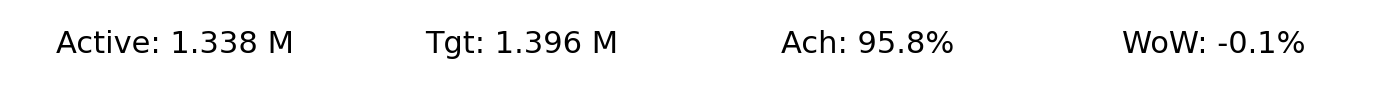

In [98]:
''' WTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(wtd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

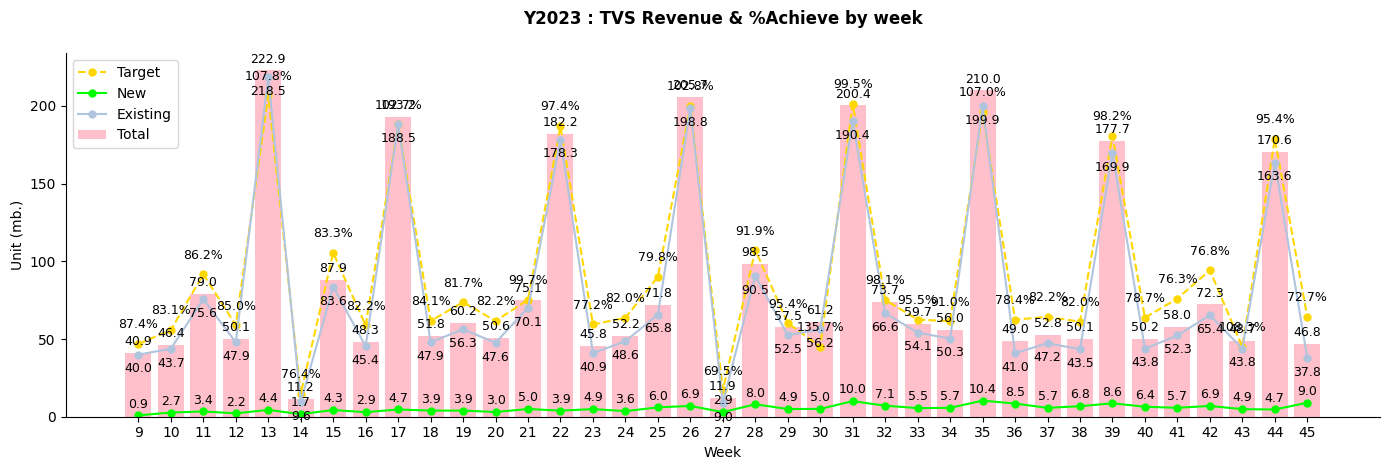

In [99]:
''' Revenue & Achieve by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Revenue & %Achieve by week\n", weight='bold')

plt.bar(x_wk_axis, unit_mb(y_wk_act), label='Total', color='pink')
plt.plot(x_wk_axis, unit_mb(y_wk_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_wk_axis, unit_mb(y_wk_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_wk_axis, unit_mb(y_wk_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')
for i in x_wk_axis:
    plt.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_tgt[i])+10), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_new[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_new[i])+5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_exist[i]),',.1f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_exist[i])-5), ha='center', va='top', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

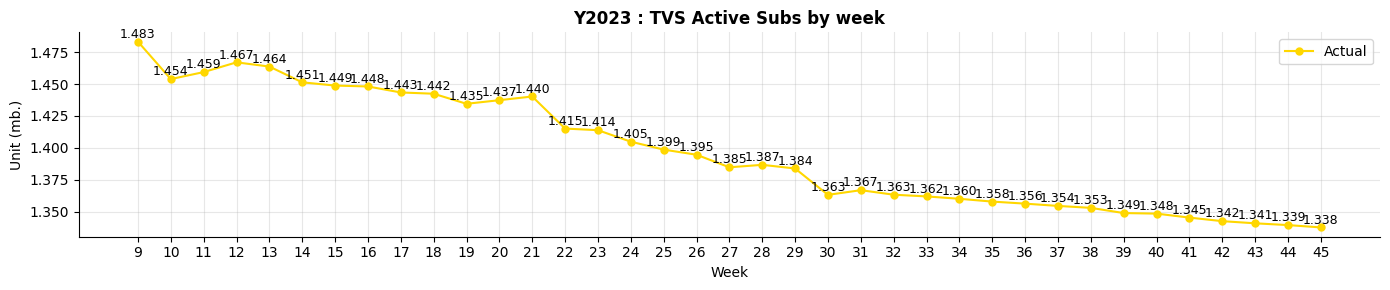

In [100]:
''' Active Subs by week '''

plt.figure(figsize=(14, 3))
plt.title(f"Y{curr_yr} : {v_product} Active Subs by week", weight='bold')

plt.plot(x_wk_axis, unit_mb(y_wk_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
# plt.plot(x_wk_axis, unit_mb(y_wk_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_wk_axis:
    plt.annotate(format(unit_mb(y_wk_act_actv_sub[i]),',.3f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.003), ha='center', fontsize=9)
    # plt.annotate(f"Ach:{format(y_wk_achv_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.03), ha='center', fontsize=8)
    # plt.annotate(f"WoW:{format(y_wk_wow_actv_sub[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_actv_sub[i])+0.02), ha='center', fontsize=8)

plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

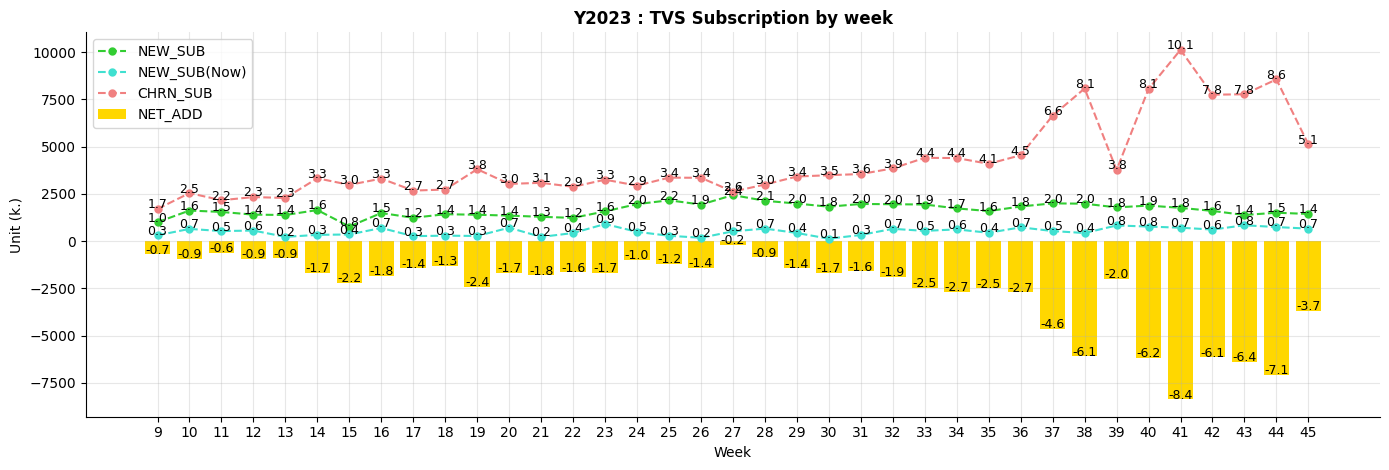

In [101]:
''' Subscription by week '''

plt.figure().set_figwidth(14)
plt.title(f"Y{curr_yr} : {v_product} Subscription by week", weight='bold')

plt.plot(x_wk_axis, y_wk_act_new_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB', color='limegreen')
plt.plot(x_wk_axis, y_wk_act_new_sub_now, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB(Now)', color='turquoise')
plt.plot(x_wk_axis, y_wk_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_wk_axis, y_wk_act_net_add, label='NET_ADD', color='gold')
for i in x_wk_axis:
    plt.annotate(format(unit_k(y_wk_act_new_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_new_sub[i]+30), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_new_sub_now[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_new_sub_now[i]+30), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_chrn_sub[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_chrn_sub[i]+30), ha='center', fontsize=9)
    plt.annotate(format(unit_k(y_wk_act_net_add[i]),',.1f'), xy=(x_wk_axis[i], y_wk_act_net_add[i]+30), ha='center', fontsize=9)

plt.xlabel('Week')
plt.ylabel('Unit (k.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [102]:
''' Create Dataframe '''

df_day_curr_mth = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_day_last_mth = df_day_agg[(df_day_agg['TM_KEY_MTH']==last_mth) & (df_day_agg['DAY_LABEL'].isin(df_day_curr_mth['DAY_LABEL']))][['TM_KEY_DAY', 'DAY_LABEL', 'ACT']].reset_index()

df_day_curr_mth_clean = df_day_curr_mth[df_day_curr_mth['ACT']['TOTAL'] > 0].reset_index()

df_day_curr_day = df_day_curr_mth_clean.loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_day_last_day = df_day_curr_mth_clean.shift().loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [103]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_day_last_day['ACT']['TOTAL'].sum()
last_day_rev_new = df_day_last_day['ACT']['NEW'].sum()
last_day_rev_exist = df_day_last_day['ACT']['EXIST'].sum()
last_day_actv_sub = df_day_last_day['ACT']['ACTV_SUB'].sum()
last_day_chrn_sub = df_day_last_day['ACT']['CHRN_SUB'].sum()
last_day_net_add = df_day_last_day['ACT']['NET_ADD'].sum()
last_day_new_sub = df_day_last_day['ACT']['NEW_SUB'].sum()
last_day_new_sub_prem = df_day_last_day['ACT']['NEW_SUB_PREM'].sum()
last_day_new_sub_mid = df_day_last_day['ACT']['NEW_SUB_MID'].sum()
last_day_new_sub_mass = df_day_last_day['ACT']['NEW_SUB_MASS'].sum()
last_day_new_sub_now = df_day_last_day['ACT']['NEW_SUB_NOW'].sum()

''' TOTAL : Values '''
dtd_rev = df_day_curr_day['ACT']['TOTAL'].sum()
dtd_tgt = df_day_curr_day['TGT']['TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_day_last_day['ACT']['TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

''' NEW : Values '''
dtd_rev_new = df_day_curr_day['ACT']['NEW'].sum()
dtd_tgt_new = df_day_curr_day['TGT']['NEW'].sum()
dtd_achv_new = dtd_rev_new / dtd_tgt_new
dtd_last_rev_new = df_day_last_day['ACT']['NEW'].sum()
dtd_dod_new = (dtd_rev_new / dtd_last_rev_new) - 1
dtd_gap_new = dtd_rev_new - dtd_last_rev_new

''' EXIST : Values '''
dtd_rev_exist = df_day_curr_day['ACT']['EXIST'].sum()
dtd_tgt_exist = df_day_curr_day['TGT']['EXIST'].sum()
dtd_achv_exist = dtd_rev_exist / dtd_tgt_exist
dtd_last_rev_exist = df_day_last_day['ACT']['EXIST'].sum()
dtd_dod_exist = (dtd_rev_exist / dtd_last_rev_exist) - 1
dtd_gap_exist = dtd_rev_exist - dtd_last_rev_exist

''' ACTV_SUB : Values '''
dtd_actv_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['ACTV_SUB'].sum()
dtd_tgt_actv_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['ACTV_SUB'].sum()
dtd_achv_actv_sub = dtd_actv_sub / dtd_tgt_actv_sub
dtd_last_actv_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['ACTV_SUB'].sum()
dtd_dod_actv_sub = (dtd_actv_sub / dtd_last_actv_sub) - 1
dtd_gap_actv_sub = dtd_actv_sub - dtd_last_actv_sub

''' CHRN_SUB : Values '''
dtd_chrn_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['CHRN_SUB'].sum()
dtd_tgt_chrn_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['CHRN_SUB'].sum()
dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
dtd_last_chrn_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['CHRN_SUB'].sum()
dtd_dod_chrn_sub = (dtd_chrn_sub / dtd_last_chrn_sub) - 1
dtd_gap_chrn_sub = dtd_chrn_sub - dtd_last_chrn_sub

''' NET_ADD : Values '''
dtd_net_add = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NET_ADD'].sum()
dtd_tgt_net_add = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NET_ADD'].sum()
dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
dtd_last_net_add = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NET_ADD'].sum()
dtd_dod_net_add = (dtd_net_add / dtd_last_net_add) - 1
dtd_gap_net_add = dtd_net_add - dtd_last_net_add

''' NEW_SUB : Values '''
dtd_new_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB'].sum()
dtd_tgt_new_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB'].sum()
dtd_achv_new_sub = dtd_new_sub / dtd_tgt_new_sub
dtd_last_new_sub = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB'].sum()
dtd_dod_new_sub = (dtd_new_sub / dtd_last_new_sub) - 1
dtd_gap_new_sub = dtd_new_sub - dtd_last_new_sub

''' NEW_SUB_PREM : Values '''
dtd_new_sub_prem = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_PREM'].sum()
dtd_tgt_new_sub_prem = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_PREM'].sum()
dtd_achv_new_sub_prem = dtd_new_sub_prem / dtd_tgt_new_sub_prem
dtd_last_new_sub_prem = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_PREM'].sum()
dtd_dod_new_sub_prem = (dtd_new_sub_prem / dtd_last_new_sub_prem) - 1
dtd_gap_new_sub_prem = dtd_new_sub_prem - dtd_last_new_sub_prem

''' NEW_SUB_MID : Values '''
dtd_new_sub_mid = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_MID'].sum()
dtd_tgt_new_sub_mid = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_MID'].sum()
dtd_achv_new_sub_mid = dtd_new_sub_mid / dtd_tgt_new_sub_mid
dtd_last_new_sub_mid = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_MID'].sum()
dtd_dod_new_sub_mid = (dtd_new_sub_mid / dtd_last_new_sub_mid) - 1
dtd_gap_new_sub_mid = dtd_new_sub_mid - dtd_last_new_sub_mid

''' NEW_SUB_MASS : Values '''
dtd_new_sub_mass = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_MASS'].sum()
dtd_tgt_new_sub_mass = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_MASS'].sum()
dtd_achv_new_sub_mass = dtd_new_sub_mass / dtd_tgt_new_sub_mass
dtd_last_new_sub_mass = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_MASS'].sum()
dtd_dod_new_sub_mass = (dtd_new_sub_mass / dtd_last_new_sub_mass) - 1
dtd_gap_new_sub_mass = dtd_new_sub_mass - dtd_last_new_sub_mass

''' NEW_SUB_NOW : Values '''
dtd_new_sub_now = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT']['NEW_SUB_NOW'].sum()
dtd_tgt_new_sub_now = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['TGT']['NEW_SUB_NOW'].sum()
dtd_achv_new_sub_now = dtd_new_sub_now / dtd_tgt_new_sub_now
dtd_last_new_sub_now = df_day_agg[df_day_agg['TM_KEY_DAY']==last_day]['ACT']['NEW_SUB_NOW'].sum()
dtd_dod_new_sub_now = (dtd_new_sub_now / dtd_last_new_sub_now) - 1
dtd_gap_new_sub_now = dtd_new_sub_now - dtd_last_new_sub_now

C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\4174828485.py:51: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_chrn_sub = -((dtd_chrn_sub / dtd_tgt_chrn_sub) - 1)
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\4174828485.py:59: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_net_add = dtd_net_add / dtd_tgt_net_add
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\4174828485.py:67: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_new_sub = dtd_new_sub / dtd_tgt_new_sub
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\4174828485.py:75: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_new_sub_prem = dtd_new_sub_prem / dtd_tgt_new_sub_prem
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\4174828485.py:83: RuntimeWarning: invalid value encountered in scalar divide
  dtd_achv_new_sub_mid = dtd_new_sub_mid / dtd_tgt_new_sub_mid
C:\Users\Narut4\AppData\Local\Temp\ipykernel_15400\4174828485.py:9

In [104]:
''' DTD BarH Dataframe'''

df_bar_h_dtd = df_day_agg[df_day_agg['TM_KEY_DAY']==curr_day]['ACT'][['NEW_SUB', 'NEW_SUB_NOW', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h_dtd.columns = ['METRIC_NAME', 'VALUES']

color_conditions = [df_bar_h_dtd['METRIC_NAME']=='NEW_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='NEW_SUB_NOW', 
                    df_bar_h_dtd['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h_dtd['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'turquoise', 'lightcoral', 'gold']
sort_results = [1, 2, 3, 4]

df_bar_h_dtd['COLOR'] = np.select(color_conditions, color_results)
df_bar_h_dtd['SORT_NO'] = np.select(color_conditions, sort_results)

df_bar_h_dtd = df_bar_h_dtd.sort_values(by='SORT_NO', ascending=False)
df_bar_h_dtd

,METRIC_NAME,VALUES,COLOR,SORT_NO
3,NET_ADD,NaN,gold,4
2,CHRN_SUB,NaN,lightcoral,3
1,NEW_SUB_NOW,NaN,turquoise,2
0,NEW_SUB,NaN,limegreen,1


In [105]:
''' Day Chart Values '''

x_day = df_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' TOTAL : Values '''
y_day_act = df_day_curr_mth['ACT']['TOTAL']
y_day_tgt = df_day_curr_mth['TGT']['TOTAL']
y_day_achv = df_day_curr_mth['%ACHV']['TOTAL']
y_day_gap = df_day_curr_mth['GAP']['TOTAL']
y_day_diff = df_day_curr_mth['DIFF']['TOTAL']
y_day_last_act = df_day_last_mth['ACT']['TOTAL']
y_day_dod = df_day_curr_mth['%DOD']['TOTAL']

''' NEW : Values '''
y_day_act_new = df_day_curr_mth['ACT']['NEW']
y_day_tgt_new = df_day_curr_mth['TGT']['NEW']
y_day_achv_new = df_day_curr_mth['%ACHV']['NEW']
y_day_gap_new = df_day_curr_mth['GAP']['NEW']
y_day_diff_new = df_day_curr_mth['DIFF']['NEW']
y_day_last_act_new = df_day_last_mth['ACT']['NEW']
y_day_dod_new = df_day_curr_mth['%DOD']['NEW']

''' EXIST : Values '''
y_day_act_exist = df_day_curr_mth['ACT']['EXIST']
y_day_tgt_exist = df_day_curr_mth['TGT']['EXIST']
y_day_achv_exist = df_day_curr_mth['%ACHV']['EXIST']
y_day_gap_exist = df_day_curr_mth['GAP']['EXIST']
y_day_diff_exist = df_day_curr_mth['DIFF']['EXIST']
y_day_last_act_exist = df_day_last_mth['ACT']['EXIST']
y_day_dod_exist = df_day_curr_mth['%DOD']['EXIST']

''' ACTV_SUB : Values '''
y_day_act_actv_sub = df_day_curr_mth['ACT']['ACTV_SUB']
y_day_tgt_actv_sub = df_day_curr_mth['TGT']['ACTV_SUB']
y_day_achv_actv_sub = df_day_curr_mth['%ACHV']['ACTV_SUB']
y_day_gap_actv_sub = df_day_curr_mth['GAP']['ACTV_SUB']
y_day_diff_actv_sub = df_day_curr_mth['DIFF']['ACTV_SUB']
y_day_last_act_actv_sub = df_day_last_mth['ACT']['ACTV_SUB']
y_day_dod_actv_sub = df_day_curr_mth['%DOD']['ACTV_SUB']

''' CHRN_SUB : Values '''
y_day_act_chrn_sub = df_day_curr_mth['ACT']['CHRN_SUB']
y_day_tgt_chrn_sub = df_day_curr_mth['TGT']['CHRN_SUB']
y_day_achv_chrn_sub = df_day_curr_mth['%ACHV']['CHRN_SUB']
y_day_gap_chrn_sub = df_day_curr_mth['GAP']['CHRN_SUB']
y_day_diff_chrn_sub = df_day_curr_mth['DIFF']['CHRN_SUB']
# y_day_last_act_chrn_sub = df_day_curr_mth['LAST_ACT']['CHRN_SUB']
y_day_last_act_chrn_sub = df_day_last_mth['ACT']['CHRN_SUB']
y_day_dod_chrn_sub = df_day_curr_mth['%DOD']['CHRN_SUB']

''' NET_ADD : Values '''
y_day_act_net_add = df_day_curr_mth['ACT']['NET_ADD']
y_day_tgt_net_add = df_day_curr_mth['TGT']['NET_ADD']
y_day_achv_net_add = df_day_curr_mth['%ACHV']['NET_ADD']
y_day_gap_net_add = df_day_curr_mth['GAP']['NET_ADD']
y_day_diff_net_add = df_day_curr_mth['DIFF']['NET_ADD']
# y_day_last_act_net_add = df_day_curr_mth['LAST_ACT']['NET_ADD']
y_day_last_act_net_add = df_day_last_mth['ACT']['NET_ADD']
y_day_dod_net_add = df_day_curr_mth['%DOD']['NET_ADD']

''' NEW_SUB : Values '''
y_day_act_new_sub = df_day_curr_mth['ACT']['NEW_SUB']
y_day_tgt_new_sub = df_day_curr_mth['TGT']['NEW_SUB']
y_day_achv_new_sub = df_day_curr_mth['%ACHV']['NEW_SUB']
y_day_gap_new_sub = df_day_curr_mth['GAP']['NEW_SUB']
y_day_diff_new_sub = df_day_curr_mth['DIFF']['NEW_SUB']
# y_day_last_act_new_sub = df_day_curr_mth['LAST_ACT']['NEW_SUB']
y_day_last_act_new_sub = df_day_last_mth['ACT']['NEW_SUB']
y_day_dod_new_sub = df_day_curr_mth['%DOD']['NEW_SUB']

''' NEW_SUB_PREM : Values '''
y_day_act_new_sub_prem = df_day_curr_mth['ACT']['NEW_SUB_PREM']
y_day_tgt_new_sub_prem = df_day_curr_mth['TGT']['NEW_SUB_PREM']
y_day_achv_new_sub_prem = df_day_curr_mth['%ACHV']['NEW_SUB_PREM']
y_day_gap_new_sub_prem = df_day_curr_mth['GAP']['NEW_SUB_PREM']
y_day_diff_new_sub_prem = df_day_curr_mth['DIFF']['NEW_SUB_PREM']
# y_day_last_act_new_sub_prem = df_day_curr_mth['LAST_ACT']['NEW_SUB_PREM']
y_day_last_act_new_sub_prem = df_day_last_mth['ACT']['NEW_SUB_PREM']
y_day_dod_new_sub_prem = df_day_curr_mth['%DOD']['NEW_SUB_PREM']

''' NEW_SUB_MID : Values '''
y_day_act_new_sub_mid = df_day_curr_mth['ACT']['NEW_SUB_MID']
y_day_tgt_new_sub_mid = df_day_curr_mth['TGT']['NEW_SUB_MID']
y_day_achv_new_sub_mid = df_day_curr_mth['%ACHV']['NEW_SUB_MID']
y_day_gap_new_sub_mid = df_day_curr_mth['GAP']['NEW_SUB_MID']
y_day_diff_new_sub_mid = df_day_curr_mth['DIFF']['NEW_SUB_MID']
# y_day_last_act_new_sub_mid = df_day_curr_mth['LAST_ACT']['NEW_SUB_MID']
y_day_last_act_new_sub_mid = df_day_last_mth['ACT']['NEW_SUB_MID']
y_day_dod_new_sub_mid = df_day_curr_mth['%DOD']['NEW_SUB_MID']

''' NEW_SUB_MASS : Values '''
y_day_act_new_sub_mass = df_day_curr_mth['ACT']['NEW_SUB_MASS']
y_day_tgt_new_sub_mass = df_day_curr_mth['TGT']['NEW_SUB_MASS']
y_day_achv_new_sub_mass = df_day_curr_mth['%ACHV']['NEW_SUB_MASS']
y_day_gap_new_sub_mass = df_day_curr_mth['GAP']['NEW_SUB_MASS']
y_day_diff_new_sub_mass = df_day_curr_mth['DIFF']['NEW_SUB_MASS']
# y_day_last_act_new_sub_mass = df_day_curr_mth['LAST_ACT']['NEW_SUB_MASS']
y_day_last_act_new_sub_mass = df_day_last_mth['ACT']['NEW_SUB_MASS']
y_day_dod_new_sub_mass = df_day_curr_mth['%DOD']['NEW_SUB_MASS']

''' NEW_SUB_NOW : Values '''
y_day_act_new_sub_now = df_day_curr_mth['ACT']['NEW_SUB_NOW']
y_day_tgt_new_sub_now = df_day_curr_mth['TGT']['NEW_SUB_NOW']
y_day_achv_new_sub_now = df_day_curr_mth['%ACHV']['NEW_SUB_NOW']
y_day_gap_new_sub_now = df_day_curr_mth['GAP']['NEW_SUB_NOW']
y_day_diff_new_sub_now = df_day_curr_mth['DIFF']['NEW_SUB_NOW']
# y_day_last_act_new_sub_now = df_day_curr_mth['LAST_ACT']['NEW_SUB_NOW']
y_day_last_act_new_sub_now = df_day_last_mth['ACT']['NEW_SUB_NOW']
y_day_dod_new_sub_now = df_day_curr_mth['%DOD']['NEW_SUB_NOW']

### DAY : Visualizations

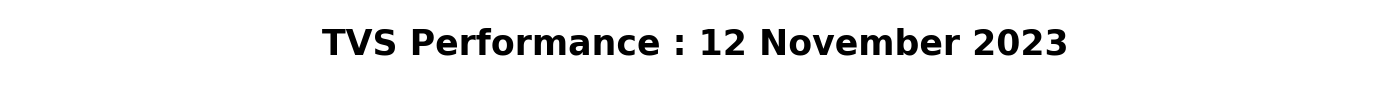

In [106]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

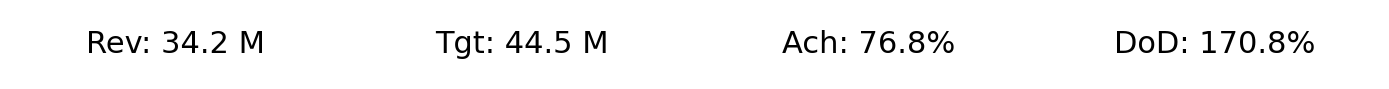

In [107]:
''' DTD Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Rev: {format(unit_mb(dtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

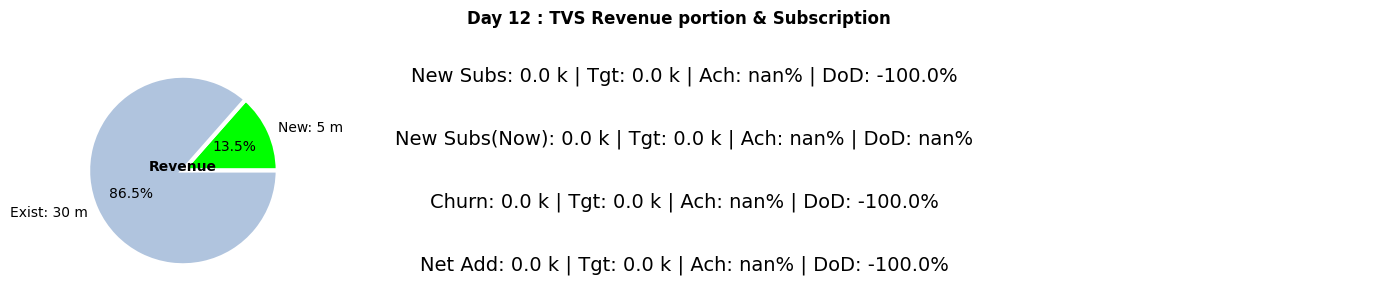

In [108]:
'''' Revenue Portion & Subscription '''

fig = plt.figure(figsize=(14, 3))
fig.suptitle(f'Day {curr_day_label} : {v_product} Revenue portion & Subscription', weight='bold')
gs = GridSpec(4, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])
ax6 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(dtd_rev_new.sum()), unit_mb(dtd_rev_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=10, weight='bold')

''' ax2 '''
ax2.text(0.5, 0.5, 
         f"New Subs: {format(unit_k(dtd_new_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_new_sub),',.1f')} k | Ach: {format(dtd_achv_new_sub,',.1%')} | DoD: {format(dtd_dod_new_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

''' ax3 '''
ax3.text(0.5, 0.5, 
         f"New Subs(Now): {format(unit_k(dtd_new_sub_now),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_new_sub_now),',.1f')} k | Ach: {format(dtd_achv_new_sub_now,',.1%')} | DoD: {format(dtd_dod_new_sub_now,',.1%')}", 
         size=14, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

''' ax4 '''
ax4.text(0.5, 0.5, 
         f"Churn: {format(unit_k(dtd_chrn_sub),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_chrn_sub),',.1f')} k | Ach: {format(dtd_achv_chrn_sub,',.1%')} | DoD: {format(dtd_dod_chrn_sub,',.1%')}", 
         size=14, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

''' ax5 '''
ax5.text(0.5, 0.5, 
         f"Net Add: {format(unit_k(dtd_net_add),',.1f')} k | Tgt: {format(unit_k(dtd_tgt_net_add),',.1f')} k | Ach: {format(dtd_achv_net_add,',.1%')} | DoD: {format(dtd_dod_net_add,',.1%')}", 
         size=14, ha='center', va='center')
ax5.spines[['top','left','right','bottom']].set_visible(False)
ax5.set_axis_off()

''' ax6 '''
bars = ax6.barh(df_bar_h_dtd['METRIC_NAME'], width=unit_k(df_bar_h_dtd['VALUES']), color=df_bar_h_dtd['COLOR'])
ax6.bar_label(bars, padding=5, fmt='%.1f k')
ax6.spines[['top','left','right','bottom']].set_visible(False)
ax6 = plt.gca()
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

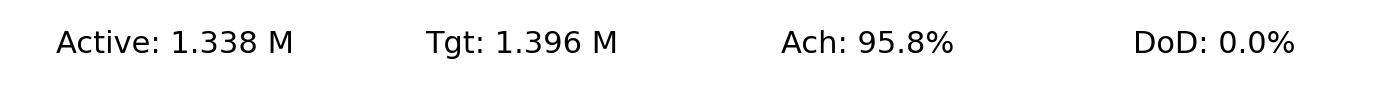

In [109]:
''' DTD Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active: {format(unit_mb(dtd_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt_actv_sub),',.3f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod_actv_sub,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

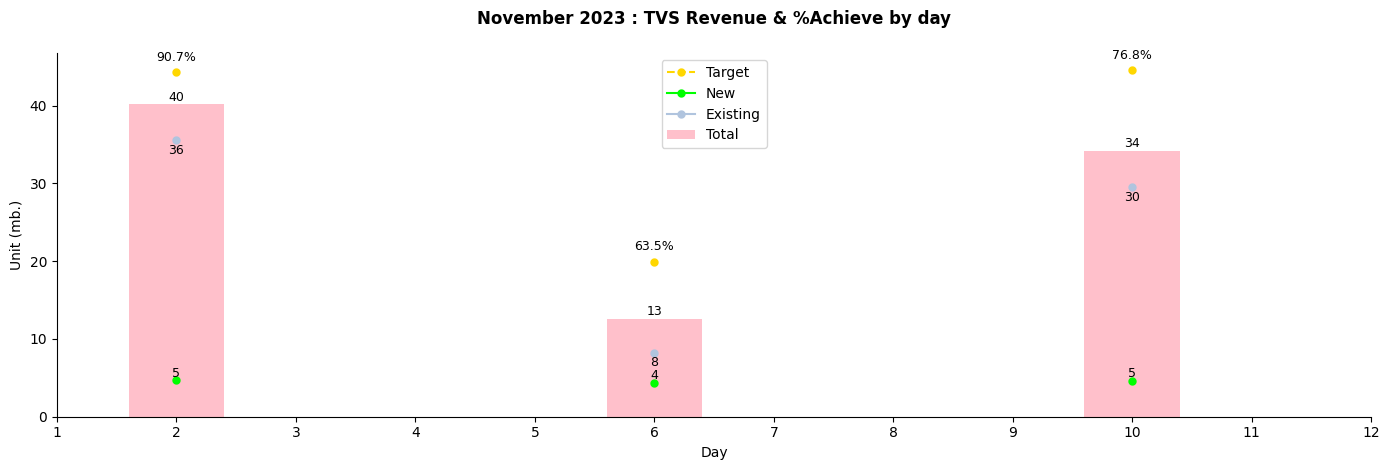

In [110]:
''' Revenue & Achieve by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Revenue & %Achieve by day\n", weight='bold')

plt.bar(x_day_axis, unit_mb(y_day_act), label='Total', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_act_new), marker='.', markeredgewidth=3, label='New', color='lime')
plt.plot(x_day_axis, unit_mb(y_day_act_exist), marker='.', markeredgewidth=3, label='Existing', color='lightsteelblue')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_tgt[i])+1.5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+0.5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_new[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_new[i])+0.5), ha='center', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_exist[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_exist[i])-0.5), ha='center', va='top', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

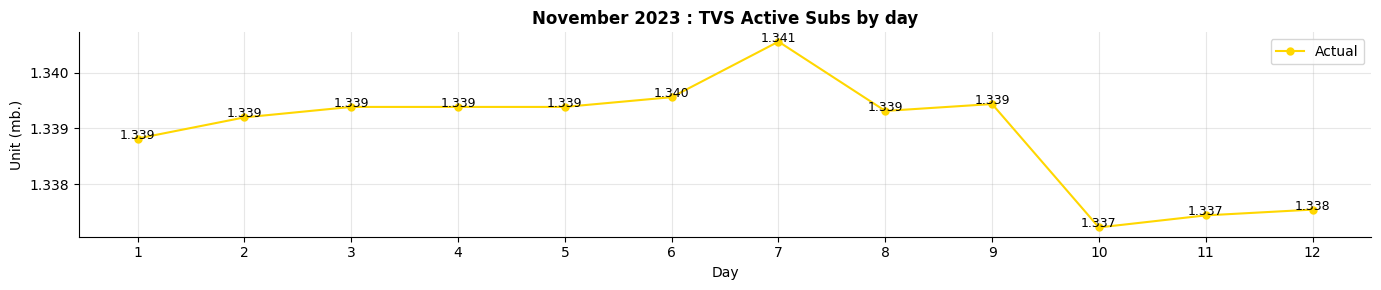

In [111]:
''' Active Subs by day '''

plt.figure(figsize=(14, 3))
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Active Subs by day", weight='bold')

plt.plot(x_day_axis, unit_mb(y_day_act_actv_sub), marker='.', markeredgewidth=3, label='Actual', color='gold')
# plt.plot(x_day_axis, unit_mb(y_day_tgt_actv_sub), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='grey')
for i in x_day_axis:
    plt.annotate(format(unit_mb(y_day_act_actv_sub[i]),',.3f'), xy=(x_day_axis[i], unit_mb(y_day_act_actv_sub[i])), ha='center', fontsize=9) #+0.001

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

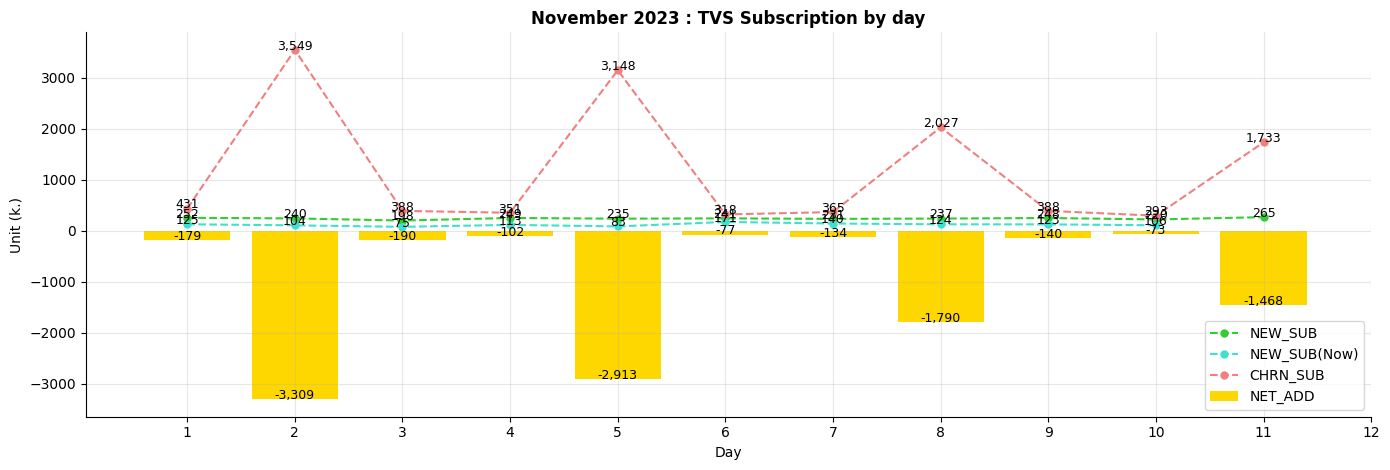

In [112]:
''' Subscription by day '''

plt.figure().set_figwidth(14)
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Subscription by day", weight='bold')

plt.plot(x_day_axis, y_day_act_new_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB', color='limegreen')
plt.plot(x_day_axis, y_day_act_new_sub_now, marker='.', linestyle='dashed', markeredgewidth=3, label='NEW_SUB(Now)', color='turquoise')
plt.plot(x_day_axis, y_day_act_chrn_sub, marker='.', linestyle='dashed', markeredgewidth=3, label='CHRN_SUB', color='lightcoral')
plt.bar(x_day_axis, y_day_act_net_add, label='NET_ADD', color='gold')
for i in x_day_axis:
    plt.annotate(format(y_day_act_new_sub[i],',.0f'), xy=(x_day_axis[i], y_day_act_new_sub[i]+5), ha='center', fontsize=9)
    plt.annotate(format(y_day_act_new_sub_now[i],',.0f'), xy=(x_day_axis[i], y_day_act_new_sub_now[i]+5), ha='center', fontsize=9)
    plt.annotate(format(y_day_act_chrn_sub[i],',.0f'), xy=(x_day_axis[i], y_day_act_chrn_sub[i]+5), ha='center', fontsize=9)
    plt.annotate(format(y_day_act_net_add[i],',.0f'), xy=(x_day_axis[i], y_day_act_net_add[i]+5), ha='center', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (k.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()